### Eyring Analysis

The goal of this workbook is to take data generated from kinetics experiments at varying temperatures and calculate 
the transition state thermodynamic properties. 

James McCormick and Kimberly Reynolds 2024. 

This notebook is the companion to Spectra_melt_analysis. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable # for adding color bars to bar plots, etc. 
from matplotlib import rcParams #for changing the global font size
#from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd 
from scipy import stats
import scipy.constants as sc
import sklearn
from sklearn.linear_model import LinearRegression
import csv
import statsmodels.formula.api as sm
import seaborn as sns
from pathlib import Path #introduced in Python 3.4
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm

#output the conda environment
#conda env export > thermal_kinetics.yml

In [2]:
#change global font settings in plots: 
rcParams['font.family'] = "Arial"
rcParams.update({"axes.grid" : True, "grid.color": "#999999"})
rcParams['lines.markersize'] = 10
rcParams.update({'font.size': 14})

In [3]:
#should we save our output files to pdf?
#change this to 'yes' to save outputs to pdf. 
to_plot = "no"

This function is to import the eyring data that is located in ./input_data/eyring. 
The csv files contain the results of three eyring experiments of kcat measurements at a range of temperatures formatted as ln(kcat/t) vs 1/T
The data is the slope of the first 15 seconds of kinetics (see methods).

In [4]:
def import_data(csv, csv_start,csv_end):
    #load in the eyring information (ln(kcat/t) vs 1/T) as a pandas dataframe
    #dl121_eyring_pd = pd.read_csv("./input_data/eyring/m16p_eyring.csv")
    dl121_eyring_pd = pd.read_csv(csv)
    #pull out the data into a pandas dataframe
    dark_list = []
    df1 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                            , 'y': dl121_eyring_pd['Dark 1'][csv_start:csv_end]})
    dark_list.append(df1)
    df2 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                        , 'y': dl121_eyring_pd['Dark 2'][csv_start:csv_end]})
    dark_list.append(df2)
    #dark_df = dark_df.append(df2, ignore_index = True) #append depreciated in pandas
    df3 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                        , 'y': dl121_eyring_pd['Dark 3'][csv_start:csv_end]})
    dark_list.append(df3)
    dark_df = pd.concat(dark_list)
    #dark_df = dark_df.append(df3, ignore_index = True) #append depreciated in pandas
    #dark_df['x']
    lit_list = []
    ldf1 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                           , 'y': dl121_eyring_pd['Lit 1'][csv_start:csv_end]})
    lit_list.append(ldf1)
    ldf2 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                         , 'y': dl121_eyring_pd['Lit 2'][csv_start:csv_end]})
    lit_list.append(ldf2)
    #lit_df = lit_df.append(Ldf2, ignore_index = True) #append depreciated in pandas
    ldf3 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                         , 'y': dl121_eyring_pd['Lit 3'][csv_start:csv_end]})
    lit_list.append(ldf3)
    lit_df = pd.concat(lit_list)
    #lit_df = lit_df.append(ldf3, ignore_index = True) #append depreciated in pandas
    #lit_df['x']
    return dark_df, lit_df

function to plot the dataframes fed into it. No returns other than printing a plot. 

In [5]:
def classic_plot(dark_df,lit_df,mut,to_plot):  
    #dark_df is the dark pandas dataframe to be plotted. 
    #lit_df is the dark pandas dataframe to be plotted. 
    #mut is the mutant name.
    #to_plot is the variable from above to change if the plot should be written as a pdf. 


    
   ##dark
    ols_model = sm.ols(formula = 'y ~ x', data=dark_df)
    dark_results = ols_model.fit()
    
    # coefficients
    print('Intercept, x-Slope : {}'.format(dark_results.params))
    dark_y_pred = ols_model.fit().predict(dark_df['x'])
    
    # plot results
    plt.scatter(dark_df['x'], dark_df['y'])
    plt.plot(dark_df['x'], dark_y_pred, linewidth=2)
    plt.grid(True)
    plt.xlabel('1/T (K)')
    plt.ylabel('ln(kcat/T)')
    plt.title('Dark %s' % mut)
    plt.show()
    print(dark_results.summary())
    
   ##lit
    ols_model = sm.ols(formula = 'y ~ x', data=lit_df)
    lit_results = ols_model.fit()
    
    # coefficients
    print('Intercept, x-Slope : {}'.format(lit_results.params))
    lit_y_pred = ols_model.fit().predict(lit_df['x'])
    
    # plot results
    plt.scatter(lit_df['x'], lit_df['y'])
    plt.plot(lit_df['x'], lit_y_pred, linewidth=2)
    plt.grid(True)
    plt.xlabel('1/T (K)')
    plt.ylabel('ln($k_{cat}$/T)')
    plt.title('Lit %s' % mut)
    plt.show()
    print(lit_results.summary())

  ##both
    plt.scatter(lit_df['x'], lit_df['y'], c="#0099FF" , edgecolors='black')
    plt.scatter(dark_df['x'], dark_df['y'], c="#999999" , edgecolors='black')
    plt.plot(lit_df['x'], lit_y_pred, linewidth=2, color="#0099FF")
    plt.plot(dark_df['x'], dark_y_pred, linewidth=2, color="#999999")
    plt.grid(True)
    plt.xlabel('1/T (K)')
    plt.ylabel('ln($k_{cat}$/T)')
    title = ('%s' % mut)
    plt.title(title)

    #save the plot out
    if to_plot == 'yes':
        figure_name = ('%s_eyring_scatter.pdf' % mut)
        plt.savefig('./output/eyring_scatter_plots/%s' % figure_name, bbox_inches='tight')
        
    plt.show()
    return

bootstrapping function. Feed in two dataframes of kinetics, and how many iterations of boostrapping to do, and it will return 
the iterations of the slopes and intercepts. 

In [6]:
#bootstrapping for statistics
def bootstrapping(dark_df,lit_df,bootstrapping_number):
    # resample with replacement each row
    #dark
    dark_boot_slopes = []
    dark_boot_interc = []
    n_boots = bootstrapping_number #usually 5000
    for _ in range(n_boots):
        # sample the rows, same size, with replacement
        dark_sample_df = dark_df.sample(n=len(dark_df), replace=True)
        # fit a linear regression
        dark_ols_model_temp = sm.ols(formula = 'y ~ x', data=dark_sample_df)
        dark_results_temp = dark_ols_model_temp.fit()
        
        # append coefficients
        dark_boot_interc.append(dark_results_temp.params[0])
        dark_boot_slopes.append(dark_results_temp.params[1])
        
        # plot a greyed out line
        dark_y_pred_temp = dark_ols_model_temp.fit().predict(dark_sample_df['x'])

    #lit
    lit_boot_slopes = []
    lit_boot_interc = []
    for _ in range(n_boots):
        # sample the rows, same size, with replacement
        lit_sample_df = lit_df.sample(n=len(lit_df), replace=True)
        # fit a linear regression
        lit_ols_model_temp = sm.ols(formula = 'y ~ x', data=lit_sample_df)
        lit_results_temp = lit_ols_model_temp.fit()
        
        # append coefficients
        lit_boot_interc.append(lit_results_temp.params[0])
        lit_boot_slopes.append(lit_results_temp.params[1])
        
        # plot a greyed out line
        lit_y_pred_temp = lit_ols_model_temp.fit().predict(lit_sample_df['x'])
    
    return dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc

dataframe that takes the dark output of the bootstrapping function and calculates and returns the statistics. 

In [7]:
def boot_statistics_dark(dark_boot_slopes, dark_boot_interc, mut):
    sns.displot(dark_boot_slopes)
    print('dark slopes')
    plt.title('Dark %s slope distribution' % mut)
    plt.show()
    #dark slopes statistics

    dark_slope_mean = np.mean(dark_boot_slopes)
    print("\nMean: ", dark_slope_mean)

    dark_slope_std = np.std(dark_boot_slopes)
    print("\nstd: ", dark_slope_std)

    dark_slope_var = np.var(dark_boot_slopes)
    print("\nvariance: ", dark_slope_var)

    dark_slope_conf_interval = np.percentile(dark_boot_slopes,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",dark_slope_conf_interval)
    
    #dark intercept statistics 
    sns.displot(dark_boot_interc)
    print('dark intercepts')
    plt.title('Dark %s intercept distribution' % mut)
    plt.show()
    #boot_interc

    dark_interc_mean = np.mean(dark_boot_interc)
    print("\nMean: ", dark_interc_mean)

    dark_interc_std = np.std(dark_boot_interc)
    print("\nstd: ", dark_interc_std)

    dark_interc_var = np.var(dark_boot_interc)
    print("\nvariance: ", dark_interc_var)

    dark_interc_conf_interval = np.percentile(dark_boot_interc,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",dark_interc_conf_interval)
    
    return dark_slope_mean, dark_slope_std, dark_slope_var, dark_slope_conf_interval, \
    dark_interc_mean, dark_interc_std, dark_interc_var, dark_interc_conf_interval


dataframe that takes the lit output of the bootstrapping function and calculates and returns the statistics.
The code is identical to boot_statistics_dark. 

In [8]:
def boot_statistics_lit(lit_boot_slopes, lit_boot_interc, mut):
    sns.displot(lit_boot_slopes)
    print('lit slopes')
    plt.title('Lit %s slope distribution' % mut)
    plt.show()
    #lit slopes statistics

    lit_slope_mean = np.mean(lit_boot_slopes)
    print("\nMean: ", lit_slope_mean)

    lit_slope_std = np.std(lit_boot_slopes)
    print("\nstd: ", lit_slope_std)

    lit_slope_var = np.var(lit_boot_slopes)
    print("\nvariance: ", lit_slope_var)

    lit_slope_conf_interval = np.percentile(lit_boot_slopes,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",lit_slope_conf_interval)
    
    #lit intercept statistics 
    sns.displot(lit_boot_interc)
    print('lit intercepts')
    plt.title('Lit %s intercept distribution' % mut)
    plt.show()
    #boot_interc

    lit_interc_mean = np.mean(lit_boot_interc)
    print("\nMean: ", lit_interc_mean)

    lit_interc_std = np.std(lit_boot_interc)
    print("\nstd: ", lit_interc_std)

    lit_interc_var = np.var(lit_boot_interc)
    print("\nvariance: ", lit_interc_var)

    lit_interc_conf_interval = np.percentile(lit_boot_interc,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",lit_interc_conf_interval)
    
    return lit_slope_mean, lit_slope_std, lit_slope_var, lit_slope_conf_interval, \
    lit_interc_mean, lit_interc_std, lit_interc_var, lit_interc_conf_interval


### Now to propagate into entropy and enthalpy and compare error

In [9]:
def calc_energetics(dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc,mut):
#dark
    dark_enthalpy_list = []
    dark_entropy_list = []
    for x in dark_boot_slopes: #to get enthalpy 
        #multiply by negative R, in cal/K/mol 
        dark_enthalpy_temp = np.multiply(x,-1.98720425864083)
        #convert to kcal/mol
        dark_enthalpy_kcal = np.multiply(dark_enthalpy_temp, 0.001)
        dark_enthalpy_list.append(dark_enthalpy_kcal)
    for y in dark_boot_interc:
        dark_entropy_temp = np.multiply(y,1.98720425864083) #multiply by R, gas constant. 
        dark_entropy_temp_2 = np.subtract(dark_entropy_temp,47.2163540817713) #subtract R*ln(kb/h)
        dark_entropy_list.append(dark_entropy_temp_2)
    #lit 
    lit_enthalpy_list = []
    lit_entropy_list = []
    for x in lit_boot_slopes: #to get enthalpy 
        #multiply by negative R, in cal/K/mol 
        lit_enthalpy_temp = np.multiply(x,-1.98720425864083)
        #convert to kcal/mol
        lit_enthalpy_kcal = np.multiply(lit_enthalpy_temp, 0.001)
        lit_enthalpy_list.append(lit_enthalpy_kcal)
    for y in lit_boot_interc:
        lit_entropy_temp = np.multiply(y,1.98720425864083) #multiply by R, gas constant. 
        lit_entropy_temp_2 = np.subtract(lit_entropy_temp,47.2163540817713) #subtract R*ln(kb/h)
        lit_entropy_list.append(lit_entropy_temp_2)
    #enthalpy
    print('dark enthalpy')
    dark_enthalpy_mean = np.mean(dark_enthalpy_list)
    print("\nMean: ", dark_enthalpy_mean)

    dark_enthalpy_std = np.std(dark_enthalpy_list)
    print("\nstd: ", dark_enthalpy_std)

    dark_enthalpy_var = np.var(dark_enthalpy_list)
    print("\nvariance: ", dark_enthalpy_var)

    conf_interval = np.percentile(dark_enthalpy_list,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(dark_enthalpy_list)
    plt.title('Dark %s enthalpy distribution' % mut)
    plt.show()

    print('lit enthalpy')
    lit_enthalpy_mean = np.mean(lit_enthalpy_list)
    print("\nMean: ", lit_enthalpy_mean)

    lit_enthalpy_std = np.std(lit_enthalpy_list)
    print("\nstd: ", lit_enthalpy_std)

    lit_enthalpy_var = np.var(lit_enthalpy_list)
    print("\nvariance: ", lit_enthalpy_var)

    conf_interval = np.percentile(lit_enthalpy_list,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(lit_enthalpy_list)
    plt.title('Lit %s Enthalpy distribution' % mut)
    plt.show()

    #are they different?
    statistic,pvalue = stats.ttest_ind(dark_enthalpy_list, lit_enthalpy_list, equal_var=False)
    print("p value that enthalpy are different: ",pvalue)
    #entropy
    print('dark entropy')
    dark_entropy_mean = np.mean(dark_entropy_list)
    print("\nMean: ", dark_entropy_mean)

    dark_entropy_std = np.std(dark_entropy_list)
    print("\nstd: ", dark_entropy_std)

    dark_entropy_var = np.var(dark_entropy_list)
    print("\nvariance: ", dark_entropy_var)

    conf_interval = np.percentile(dark_entropy_list,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(dark_entropy_list)
    plt.title('Dark %s entropy distribution' % mut)
    plt.show()

    print('lit entropy')
    lit_entropy_mean = np.mean(lit_entropy_list)
    print("\nMean: ", lit_entropy_mean)

    lit_entropy_std = np.std(lit_entropy_list)
    print("\nstd: ", lit_entropy_std)

    lit_entropy_var = np.var(lit_entropy_list)
    print("\nvariance: ", lit_entropy_var)

    conf_interval = np.percentile(lit_entropy_list,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(lit_entropy_list)
    plt.title('Dark %s entropy distribution' % mut)
    plt.show()
    #is lit different than dark. 

    #are they different?
    statistic,pvalue = stats.ttest_ind(dark_entropy_list, lit_entropy_list, equal_var=False)
    print("p value that entropy are different: ",pvalue)

    
    return dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std,\
    dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list

### To back calculate the kcat at a temperature to check error.
### Getting from entropy and enthalpy to k
 delta G = delta H -(T * delta S)  in joules or calories per mol
 deltaH is enthalpy of activation in kcal/mol or joule
 deltaS is entropy of activation in joule per kelvin
 T is temperature in kelvin
 deltaG is the gibbs energy of activation 
 
 kcat = ((kbT)/h) * e^(-(deltaH/(RT))) * e^(deltaS/R)
 
 R is gas constant 8.31446261815324 joules/K/mol or 1.987204 cal/K/mol (calorie per kelvin per mole. 1 cal = 4.184 joules
 
 kb is the boltzmann/s constant (1.381 x 10^-23 J/K)
 
 h is Planck/s constant (6.62607 x 10^-34 J/Hz) or 1.05457 x 10^-34 Joule second (J times s)

In [10]:
def kcat_back_calculate(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list, n_boots, temp_c,mut):
    kcat_dark = []
    kcat_lit = []
    kcat_ratio = []
    i = 0
    
    #convert C to kelven 
    temperature = np.add(273.0, temp_c)
    
    #multiply temp and botzmann's constant (from scipy.constants)
    kbT = np.multiply(sc.k,temperature)
    
    #divide by planck's constant
    kbTh = np.divide(kbT, sc.h) #nb the joules units cancel out. hashtag sorry, not sorry 
    
    #RT for #e^(-(deltaH/(RT))) #using R in cal/K/mol
    RT = np.multiply(1.987204,temperature)
    
    for i in range(n_boots):
    
        #DARK ZONE
        #need to convert enthalpy from kcal to cal 
        dark_enthalpy_cal = np.multiply(dark_enthalpy_list[i],1000)
        #for the e^(-(deltaH/(RT))) term
        HRT = np.divide(-dark_enthalpy_cal,RT)
        eHRT = np.power(np.e,HRT)
        #multiply the first two sets of terms together ((kbT)/h) * e^(-(deltaH/(RT)))
        kbTheHRT = np.multiply(kbTh,eHRT)
        #for the e^(deltaS/R)
        SR = np.divide(dark_entropy_list[i],1.987204)
        eSR = np.power(np.e,SR)
        kcat_dark_temp = np.multiply(kbTheHRT,eSR)
        kcat_dark.append(kcat_dark_temp)
        
        #LIT ZONE, WATCH OUT, VARIABLE REUSE. 
        
        #need to convert enthalpy from kcal to cal 
        lit_enthalpy_cal = np.multiply(lit_enthalpy_list[i],1000)
        HRT = np.divide(-lit_enthalpy_cal,RT)
        eHRT = np.power(np.e,HRT)
        #multiply the first two sets of terms together ((kbT)/h) * e^(-(deltaH/(RT)))
        kbTheHRT = np.multiply(kbTh,eHRT)
        #for the e^(deltaS/R)
        SR = np.divide(lit_entropy_list[i],1.987204)
        eSR = np.power(np.e,SR)
        kcat_lit_temp = np.multiply(kbTheHRT,eSR)
        kcat_lit.append(kcat_lit_temp)

        #do kcat lit divided by kcat dark

        kcat_ratio_temp = np.divide(kcat_lit_temp,kcat_dark_temp)
        kcat_ratio.append(kcat_ratio_temp)
        
    #compute the stats
    #dark Kcat
    print('kcat_dark')
    kcat_dark_mean = np.mean(kcat_dark)
    print("\nkcat_dark_mean: ", kcat_dark_mean)
      
    kcat_dark_std = np.std(kcat_dark)
    print("\nstd: ", kcat_dark_std)
      
    r3 = np.var(kcat_dark)
    print("\nvariance: ", r3)
    
    conf_interval = np.percentile(kcat_dark,[2.5,97.5])
    
    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(kcat_dark)
    plt.title('Dark %s $k_{cat}$ distribution' % mut)
    plt.show()
    
    #lit Kcat
    print('Kcat_lit')
    kcat_lit_mean = np.mean(kcat_lit)
    print("\nkcat lit mean: ", kcat_lit_mean)
      
    kcat_lit_std = np.std(kcat_lit)
    print("\nstd: ", kcat_lit_std)
      
    r3 = np.var(kcat_lit)
    print("\nvariance: ", r3)
    
    conf_interval = np.percentile(kcat_lit,[2.5,97.5])
    
    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(kcat_lit)
    plt.title('Lit %s $k_{cat}$ distribution' % mut)
    plt.show()

    #ratio
    kcat_ratio_mean = np.mean(kcat_ratio)
    kcat_ratio_std = np.std(kcat_ratio)
    

    return kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std

this function calculates the gibbs free energy from the enthalpy and entropy in the ligth and dark. 
It calculates error by performing the calculations on the entire set of iterations passed to it (n_boots). 

In [11]:
#calculate delta G
def delta_g_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                       n_boots, temp_c, mut ,mute):
    dG_dark = []
    dG_lit = []
    ddelta_G = []
    i = 0
    
    #convert C to kelven 
    temperature = np.add(273.0, temp_c)
    
    
    for i in range(n_boots):
    
        #DARK ZONE
        #need to convert enthalpy from kcal to cal 
        dark_enthalpy_cal = np.multiply(dark_enthalpy_list[i],1000)
        ST = np.multiply(dark_entropy_list[i],temperature)
        dG_dark_temp = np.subtract(dark_enthalpy_cal,ST)
        dG_dark.append(dG_dark_temp)
        
        #LIT ZONE. 
        
        #need to convert enthalpy from kcal to cal 
        lit_enthalpy_cal = np.multiply(lit_enthalpy_list[i],1000)
        ST = np.multiply(lit_entropy_list[i],temperature)
        dG_lit_temp = np.subtract(lit_enthalpy_cal,ST)
        dG_lit.append(dG_lit_temp)
        
        #take delta G to get allosteric effect of the mutant. 
    
        temp_ddelta_G = np.subtract(dG_lit[i],dG_dark[i])
        ddelta_G.append(temp_ddelta_G)
        
    #compute the stats
    #dark deltaG G dark')
    
    dG_dark_mean = np.mean(dG_dark)      
    dG_dark_std = np.std(dG_dark)
    r3 = np.var(dG_dark)
    
    conf_interval = np.percentile(dG_dark,[2.5,97.5])
    
    if mute == 'no_mute':    
        print('delta G dark')
        print("\nMean: ", dG_dark_mean)
        print("\nstd: ", dG_dark_std)
        print("\nvariance: ", r3)  
    # Print the interval
        print("The 95% confidence interval: ",conf_interval)
        sns.displot(dG_dark)
        plt.title('Dark %s dG distribution' % mut)
        plt.show()
    
    #lit deltaG

    dG_lit_mean = np.mean(dG_lit)
    dG_lit_std = np.std(dG_lit)
    r3 = np.var(dG_lit)
    conf_interval = np.percentile(dG_lit,[2.5,97.5])
    
    if mute == 'no_mute':    
        print('delta G lit')
        print("\nMean: ", dG_lit_mean)
        print("\nstd: ", dG_lit_std)
        print("\nvariance: ", r3)    
    # Print the interval
        print("The 95% confidence interval: ",conf_interval)
        sns.displot(dG_lit)
        plt.title('Lit %s dG distribution' % mut)
        plt.show()
    
    #delta deltaG
    
    ddelta_G_mean = np.mean(ddelta_G)
    ddelta_G_std = np.std(ddelta_G)
    r3 = np.var(ddelta_G)
    conf_interval = np.percentile(ddelta_G,[2.5,97.5])
    
    if mute == 'no_mute':    
        print('delta G lit - delta G dark (DeltaDeltaG)')
        print("\nMean: ", ddelta_G_mean)
        print("\nstd: ", ddelta_G_std)
        print("\nvariance: ", r3)
    # Print the interval
        print("The 95% confidence interval: ",conf_interval)
        sns.displot(ddelta_G)
        plt.title(' %s delta delta G distribution' % mut)
        plt.show()

    return dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std,\
    ddelta_G_mean, ddelta_G_std

plotting function for delta G values. 

In [12]:
#function to make plots of the delta G values. 
def delta_g_plotter(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                    n_boots,mut,to_plot):
    #make the lists
    dG_dark_mean_list = []
    dG_dark_std_list = []
    dG_lit_mean_list = []
    dG_lit_std_list = []
    ddelta_G_mean_list = []
    ddelta_G_std_list = []
    temperature_list = []

    #loop through the range of temperatures, 5 through 40C
    for i in range(4,95):
        temp_c = np.add(i,1)

        #cycle through the delta g calculations for each temperature
        dG_dark_mean_temp, dG_dark_std_temp, dG_lit_mean_temp, dG_lit_std_temp, ddelta_G_mean_temp, ddelta_G_std_temp \
        = delta_g_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                             n_boots, temp_c, mut,"mute")
        
        dG_dark_mean_list.append(dG_dark_mean_temp)
        dG_dark_std_list.append(dG_dark_std_temp)
        dG_lit_mean_list.append(dG_lit_mean_temp)
        dG_lit_std_list.append(dG_lit_std_temp)
        ddelta_G_mean_list.append(ddelta_G_mean_temp)
        ddelta_G_std_list.append(ddelta_G_std_temp)
        temperature_list.append(temp_c)
#least squares on dark delta G
    data_set_dark = pd.DataFrame(
        {'x': np.array(temperature_list, dtype=int),
         'y': np.array(dG_dark_mean_list, dtype=int)
        })
    ols_model = sm.ols(formula = 'y ~ x', data=data_set_dark)
    fit_results_dark = ols_model.fit()
    print('Intercept, x-Slope : {}'.format(fit_results_dark.params))
    fit_y_pred_dark = ols_model.fit().predict(data_set_dark['x'])

#least squares on lit delta G
    data_set_lit = pd.DataFrame(
        {'x': np.array(temperature_list, dtype=int),
         'y': np.array(dG_lit_mean_list, dtype=int)
        })
    ols_model = sm.ols(formula = 'y ~ x', data=data_set_lit)
    fit_results_lit = ols_model.fit()
    x_intercept_lit, slope_lit = fit_results_lit.params
    print('Intercept, x-Slope : {}'.format(fit_results_lit.params))
    fit_y_pred_lit = ols_model.fit().predict(data_set_lit['x'])
    
###fit linear model for delta delta G
    data_set = pd.DataFrame(
        {'x': np.array(temperature_list, dtype=int),
         'y': np.array(ddelta_G_mean_list, dtype=int)
        })
    ols_model = sm.ols(formula = 'y ~ x', data=data_set)
    fit_results = ols_model.fit()
    fit_y_pred = ols_model.fit().predict(data_set['x'])

    #get y intercept for delta delta G
    x_intercept_ddg, slope_ddg = fit_results.params
    y_intercept_ddg = np.divide(np.multiply(x_intercept_ddg, -1),slope_ddg)


###compute line of intersection of dark and lit
    intersect = np.add(np.multiply(y_intercept_ddg, slope_lit), x_intercept_lit)

    
###Plot lit and dark delta G.    
    plt.plot(temperature_list, fit_y_pred_dark, linewidth=2, color="#999999")
    plt.plot(temperature_list, fit_y_pred_lit, linewidth=2, color="#0099FF")

    plt.plot([y_intercept_ddg,y_intercept_ddg], [x_intercept_lit,intersect], linewidth=2, color="#999999", ls=":")
    plt.plot([0,y_intercept_ddg], [intersect,intersect], linewidth=2, color="#999999", ls=":")
    plt.text(0, intersect+0.25, ('Intersect is: %.2f' % intersect))
    plt.text(y_intercept_ddg+0.25, x_intercept_lit, ('Intercept is: %.2f' % y_intercept_ddg), rotation=90)
    #plt.scatter(temperature_list, dG_lit_mean_list, c="#0099FF" , edgecolors='black')
    #plt.scatter(temperature_list, dG_dark_mean_list, c="#999999" , edgecolors='black')
    #plt.plot(lit_df['x'], lit_y_pred, linewidth=2, color="#0099FF")
    #plt.plot(dark_df['x'], dark_y_pred, linewidth=2, color="#999999")
    plt.grid(True)
    plt.xlabel('Temperature (C)')
    plt.ylabel('delta G')
    title = ('%s' % mut)
    plt.title(title)

    #save the plot out
    if to_plot == 'yes':
        figure_name = ('%s_deltaG_vs_temp.pdf' % mut)
        plt.savefig('./output/eyring_scatter_plots/%s' % figure_name, bbox_inches='tight')
        
    plt.show()

###plot delta delta G

    print('Intercept, x-Slope: \n {}'.format(fit_results.params))
    print('Y Intercept is: %.2f' % y_intercept_ddg)
    
    #plt.scatter(temperature_list, ddelta_G_mean_list, c="#0099FF" , edgecolors='black')
    plt.plot(temperature_list, fit_y_pred, linewidth=2, color="#0099FF")
    plt.plot([y_intercept_ddg,y_intercept_ddg], [x_intercept_ddg,0], linewidth=2, color="#999999", ls=":")
    plt.plot([0,y_intercept_ddg], [0,0], linewidth=2, color="#999999", ls=":")
    plt.text(0, 0+0.25, ('Intercept is: %.2f' % y_intercept_ddg))
    plt.grid(True)
    plt.xlabel('Temperature (C)')
    plt.ylabel('delta delta G')
    title = ('%s' % mut)
    plt.title(title)

    #save the plot out
    if to_plot == 'yes':
        figure_name = ('%s_delta_deltaG_vs_temp.pdf' % mut)
        plt.savefig('./output/eyring_scatter_plots/%s' % figure_name, bbox_inches='tight')
        
    plt.show()
    
    return intersect, y_intercept_ddg

calculates the allosteric effect of enthalpy and entropy in relation to the wild type DL121. 

In [13]:
#calculate ddelta S and H
def delta_SH_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                       n_boots, temp_c, mut ,mute, \
                       dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121):
    delta_entropy = []
    delta_enthalpy = []
    ddelta_entropy = []
    ddelta_enthalpy = []
    
    i = 0
    
    #convert C to kelven 
    temperature = np.add(273.0, temp_c)
     
    for i in range(n_boots):
    
        #take delta S to get allosteric effect of the mutant. 
        #lit minus dark entropy for mutant
        temp_delta_entropy = np.subtract(lit_entropy_list[i],dark_entropy_list[i])
        #multiply by temperature to get cal/mol from cal/mol*Kelvin
        temp_delta_entropy = np.multiply(temp_delta_entropy, temperature)
    
        delta_entropy.append(temp_delta_entropy)

        #compute mutant lit-dark entropy normalized to DL121
        temp_delta_entropy_DL121 = np.subtract(lit_entropy_list_DL121[i],dark_entropy_list_DL121[i])
        temp_delta_entropy_DL121 = np.multiply(temp_delta_entropy_DL121, temperature)
        temp_ddelta_entropy = np.subtract(temp_delta_entropy,temp_delta_entropy_DL121)

        ddelta_entropy.append(temp_ddelta_entropy)
        
        #compute mutant lit-dark enthalpy 

        temp_delta_enthalpy = np.subtract(lit_enthalpy_list[i],dark_enthalpy_list[i])
        #multiply by tmperature to get cal/mol from kcal/mol
        temp_delta_enthalpy = np.multiply(temp_delta_enthalpy, 1000)
        
        delta_enthalpy.append(temp_delta_enthalpy)

        #compute mutant lit-dark enthalpy normalized to DL121
        temp_delta_enthalpy_DL121 = np.subtract(lit_enthalpy_list_DL121[i],dark_enthalpy_list_DL121[i])
        temp_delta_enthalpy_DL121 = np.multiply(temp_delta_enthalpy_DL121, 1000)
        temp_ddelta_enthalpy = np.subtract(temp_delta_enthalpy,temp_delta_enthalpy_DL121)

        ddelta_enthalpy.append(temp_ddelta_enthalpy)

    #compute the stats
    delta_entropy_mean = np.mean(delta_entropy)
    delta_entropy_std = np.std (delta_entropy)

    delta_enthalpy_mean = np.mean(delta_enthalpy)
    delta_enthalpy_std = np.std (delta_enthalpy)

    ddelta_entropy_mean = np.mean(ddelta_entropy)
    ddelta_entropy_std = np.std (ddelta_entropy)

    ddelta_enthalpy_mean = np.mean(ddelta_enthalpy)
    ddelta_enthalpy_std = np.std (ddelta_enthalpy)


    return delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std

calculates the allosteric effect of enthalpy and entropy in relation to the wild type DL121.
This function is for DL121 as the delta_SH_calculator needs the values for DL121 entropy and enthalpy as inputs.
This function does not. 

In [14]:
#calculate ddelta S and H
def delta_SH_calculator_DL121(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                       n_boots, temp_c, mut ,mute):
    delta_entropy = []
    delta_enthalpy = []
    ddelta_entropy = []
    ddelta_enthalpy = []
    
    i = 0
    
    #convert C to kelven 
    temperature = np.add(273.0, temp_c)
     
    for i in range(n_boots):
    
        #take delta S to get allosteric effect of the mutant. 
        #lit minus dark entropy for mutant
        temp_delta_entropy = np.subtract(lit_entropy_list[i],dark_entropy_list[i])
        #multiply by temperature to get cal/mol from cal/mol*Kelvin
        temp_delta_entropy = np.multiply(temp_delta_entropy, temperature)
    
        delta_entropy.append(temp_delta_entropy)

        #compute mutant lit-dark entropy normalized to DL121
        temp_delta_entropy_DL121 = np.subtract(lit_entropy_list[i],dark_entropy_list[i])
        temp_delta_entropy_DL121 = np.multiply(temp_delta_entropy_DL121, temperature)
        temp_ddelta_entropy = np.subtract(temp_delta_entropy,temp_delta_entropy_DL121)

        ddelta_entropy.append(temp_ddelta_entropy)
        
        #compute mutant lit-dark enthalpy 

        temp_delta_enthalpy = np.subtract(lit_enthalpy_list[i],dark_enthalpy_list[i])
        #multiply by tmperature to get cal/mol from kcal/mol
        temp_delta_enthalpy = np.multiply(temp_delta_enthalpy, 1000)
        
        delta_enthalpy.append(temp_delta_enthalpy)

        #compute mutant lit-dark enthalpy normalized to DL121
        temp_delta_enthalpy_DL121 = np.subtract(lit_enthalpy_list[i],dark_enthalpy_list[i])
        temp_delta_enthalpy_DL121 = np.multiply(temp_delta_enthalpy_DL121, 1000)
        temp_ddelta_enthalpy = np.subtract(temp_delta_enthalpy,temp_delta_enthalpy_DL121)

        ddelta_enthalpy.append(temp_ddelta_enthalpy)

    #compute the stats
    delta_entropy_mean = np.mean(delta_entropy)
    delta_entropy_std = np.std (delta_entropy)

    delta_enthalpy_mean = np.mean(delta_enthalpy)
    delta_enthalpy_std = np.std (delta_enthalpy)

    ddelta_entropy_mean = np.mean(ddelta_entropy)
    ddelta_entropy_std = np.std (ddelta_entropy)

    ddelta_enthalpy_mean = np.mean(ddelta_enthalpy)
    ddelta_enthalpy_std = np.std (ddelta_enthalpy)


    return delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std

This function calls all the above functions with file path  locations, temperature, and bootstrapping as inputs. 
It returns all the energetics paramaters and their statistics for DL121
This is done so that the DL121 values can be fed into the lower enthalpy_entropy_looper.
Which need the values of DL121 as an input to calculate normalized values. 

In [15]:
#function for calculating enthalpy and entropy with error from bootstrapping specific to DL121.
#this is done so that the DL121 values can be fed into the lower enthalpy_entropy_looper \
#which need the values of DL121 as an input to calculate normalized values. 
def enthalpy_entropy_looper_DL121(csv_path,bootstrap_number,csv_start,csv_end,temp_c,mut,to_plot):
  #this section runs all the above functions. "A function of functions"
    dark_df, lit_df = import_data(csv_path,csv_start,csv_end)

    classic_plot(dark_df,lit_df,mut,to_plot)
    
    dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc \
    = bootstrapping(dark_df,lit_df,bootstrap_number)

    
    dark_slope_mean, dark_slope_std, dark_slope_var, dark_slope_conf_interval,\
    dark_interc_mean, dark_interc_std, dark_interc_var, dark_interc_conf_interval\
    = boot_statistics_dark(dark_boot_slopes, dark_boot_interc,mut)

    
    lit_slope_mean, lit_slope_std, lit_slope_var, lit_slope_conf_interval,\
    lit_interc_mean, lit_interc_std, lit_interc_var, lit_interc_conf_interval\
    = boot_statistics_lit(lit_boot_slopes, lit_boot_interc,mut)


    dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
    dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list \
    = calc_energetics(dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc,mut)

    
    kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std \
    = kcat_back_calculate(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list, bootstrap_number, temp_c, mut)

    
    dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std \
    = delta_g_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                         bootstrap_number, temp_c, mut,"no_mute")
    calculated_intersect, calculated_intercept \
    = delta_g_plotter(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                    bootstrap_number,mut,to_plot)
    
    delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std \
    = delta_SH_calculator_DL121(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                         bootstrap_number, temp_c, mut,"no_mute")
    
    return dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
    kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
    dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
    calculated_intersect, calculated_intercept, \
    delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std, \
    dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list

This function calls all the above functions with file path  locations, temperature, DL121 energetic values, and bootstrapping as inputs. 
It returns all the energetics paramaters and their statistics. 

In [18]:
#function for calculating enthalpy and entropy with error from bootstrapping
def enthalpy_entropy_looper(csv_path,bootstrap_number,csv_start,csv_end,temp_c,mut,to_plot, \
                           dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121):
  #this section runs all the above functions. "A function of functions"
    dark_df, lit_df = import_data(csv_path,csv_start,csv_end)

    classic_plot(dark_df,lit_df,mut,to_plot)
    
    dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc \
    = bootstrapping(dark_df,lit_df,bootstrap_number)

    
    dark_slope_mean, dark_slope_std, dark_slope_var, dark_slope_conf_interval,\
    dark_interc_mean, dark_interc_std, dark_interc_var, dark_interc_conf_interval\
    = boot_statistics_dark(dark_boot_slopes, dark_boot_interc,mut)

    
    lit_slope_mean, lit_slope_std, lit_slope_var, lit_slope_conf_interval,\
    lit_interc_mean, lit_interc_std, lit_interc_var, lit_interc_conf_interval\
    = boot_statistics_lit(lit_boot_slopes, lit_boot_interc,mut)


    dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
    dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list \
    = calc_energetics(dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc,mut)

    
    kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std \
    = kcat_back_calculate(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list, bootstrap_number, temp_c, mut)

    
    dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std \
    = delta_g_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                         bootstrap_number, temp_c, mut,"no_mute")
    calculated_intersect, calculated_intercept \
    = delta_g_plotter(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                    bootstrap_number,mut,to_plot)

    delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std \
    = delta_SH_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                         bootstrap_number, temp_c, mut,"no_mute", \
                         dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121)
    
    return dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
    kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
    dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
    calculated_intersect, calculated_intercept, \
    delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std

This section runs the functions for each proten, plots them, calls the energetics calculations, and saves them into a 
pandas dataframe named energetics_df_all. This is done for kinetics measurments between 5 and 35C with 5000 iterations of boostrapping.
The fairly large iterations of bootstrapping results in this cell taking about 15 minutes to run. 

######################## DL121 ########################
Intercept, x-Slope : Intercept      15.022502
x           -6347.365566
dtype: float64


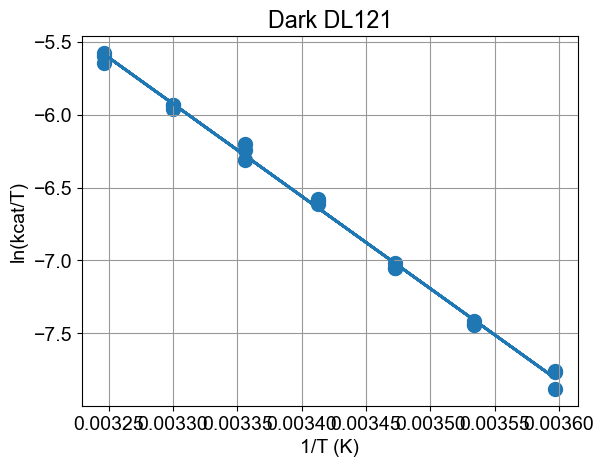

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     6230.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           2.21e-25
Time:                        12:33:57   Log-Likelihood:                 37.315
No. Observations:                  21   AIC:                            -70.63
Df Residuals:                      19   BIC:                            -68.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.0225      0.275     54.639      0.0

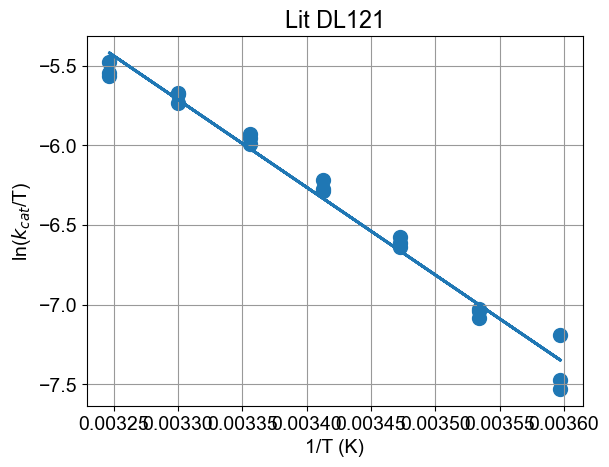

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     960.5
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           9.87e-18
Time:                        12:33:57   Log-Likelihood:                 20.691
No. Observations:                  21   AIC:                            -37.38
Df Residuals:                      19   BIC:                            -35.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4382      0.607     20.498      0.0

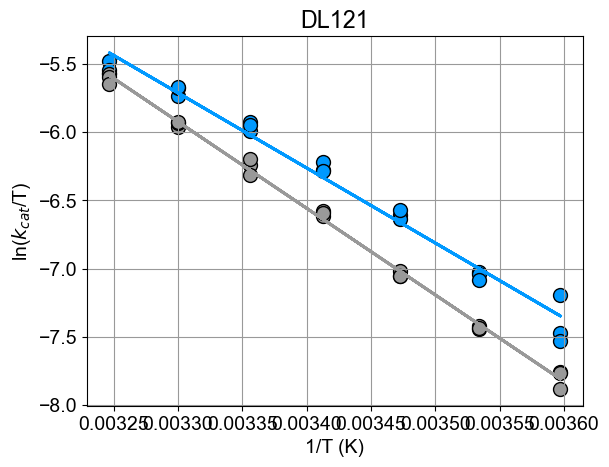

dark slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


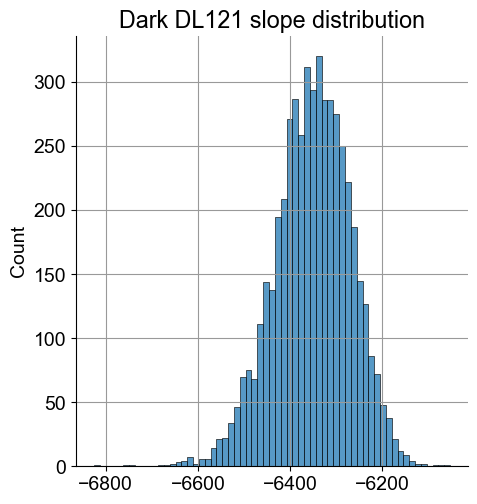


Mean:  -6352.2348720928985

std:  82.65041163478539

variance:  6831.0905433994685
The 95% confidence interval:  [-6522.76274855 -6202.6920377 ]
dark intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


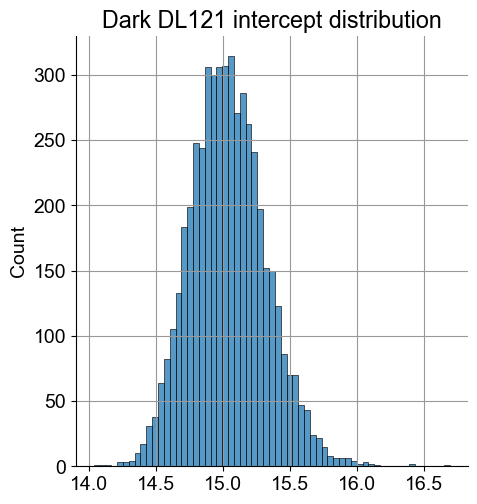


Mean:  15.039453426702378

std:  0.28161691729602994

variance:  0.07930808810731896
The 95% confidence interval:  [14.52977571 15.62432775]
lit slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


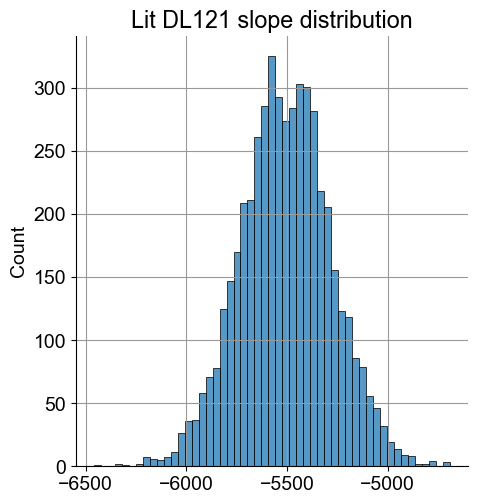


Mean:  -5507.10029175379

std:  226.1292929752589

variance:  51134.45714149047
The 95% confidence interval:  [-5957.65357691 -5064.82328755]
lit intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


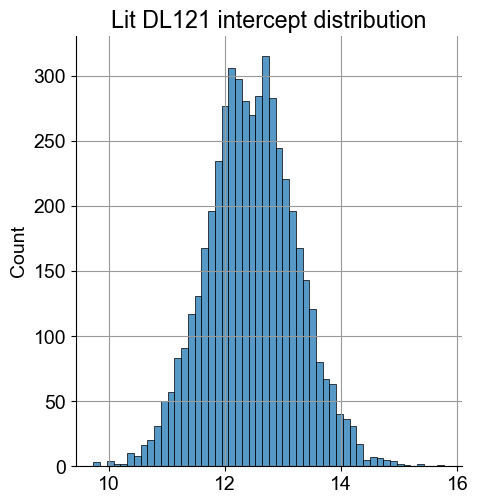


Mean:  12.463333533291289

std:  0.768623196723198

variance:  0.5907816185409879
The 95% confidence interval:  [10.98041074 14.00315872]
dark enthalpy

Mean:  12.623188189709795

std:  0.16424324997906314

variance:  0.02697584516368503
The 95% confidence interval:  [12.32601603 12.96206191]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


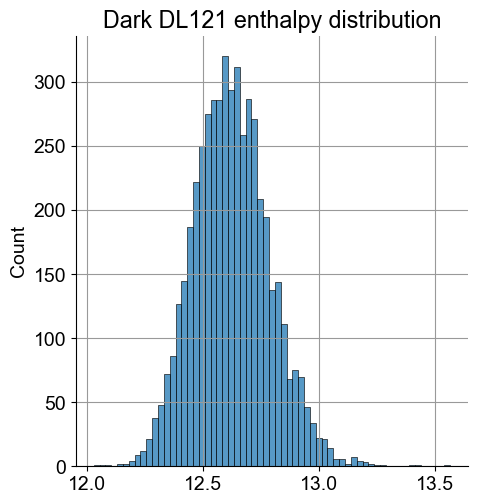

lit enthalpy

Mean:  10.94373315253529

std:  0.4493650940038744

variance:  0.2019289877091109
The 95% confidence interval:  [10.06483841 11.83907456]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


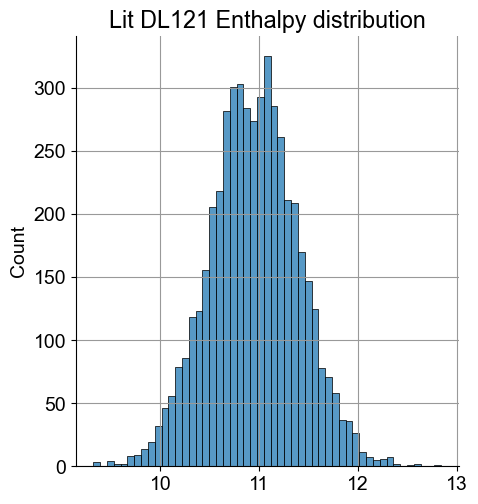

p value that enthalpy are different:  0.0
dark entropy

Mean:  -17.329888184597912

std:  0.5596303373559731

variance:  0.3131861144891603
The 95% confidence interval:  [-18.34272191 -16.16762344]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


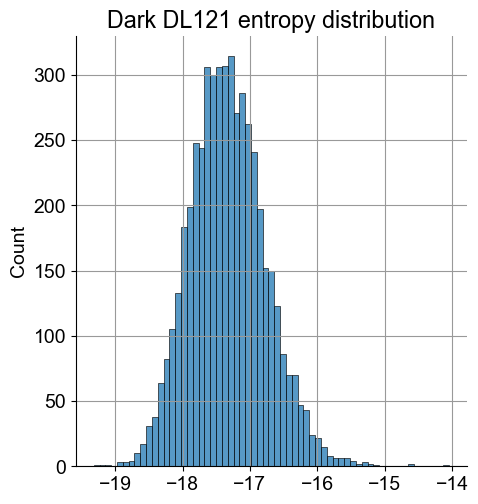

lit entropy

Mean:  -22.449164607553787

std:  1.5274112898184675

variance:  2.3329852482649143
The 95% confidence interval:  [-25.39603511 -19.38921744]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


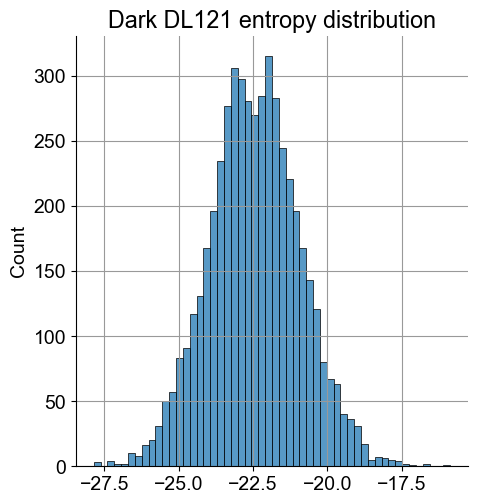

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.31484611073712937

std:  0.003045858879639736

variance:  9.277256314680227e-06
The 95% confidence interval:  [0.30904733 0.32102447]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


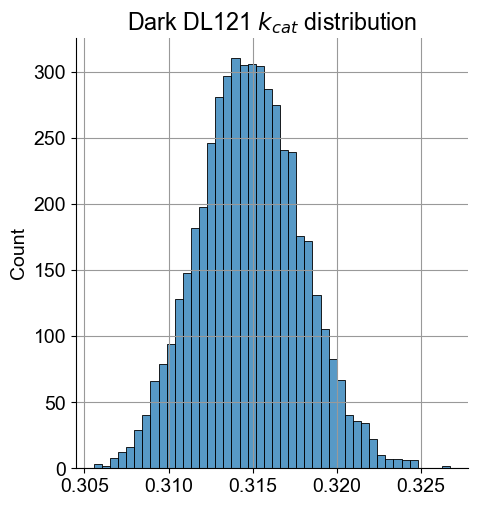

Kcat_lit

kcat lit mean:  0.4394025719086385

std:  0.009983057837672914

variance:  9.966144379032259e-05
The 95% confidence interval:  [0.42094128 0.45996156]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


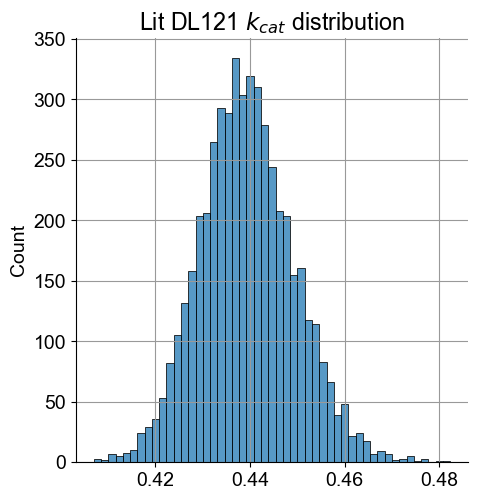

delta G dark

Mean:  17657.52070733549

std:  5.582063248886463

variance:  31.1594301145689
The 95% confidence interval:  [17646.27516916 17668.22513832]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


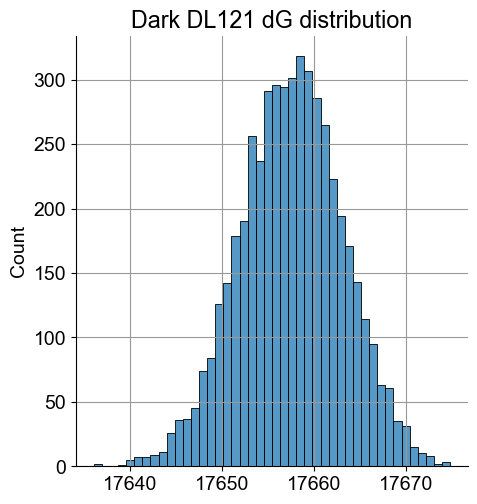

delta G lit

Mean:  17465.215471029664

std:  13.090455456777855

variance:  171.36002406588514
The 95% confidence interval:  [17438.66952472 17489.84539478]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


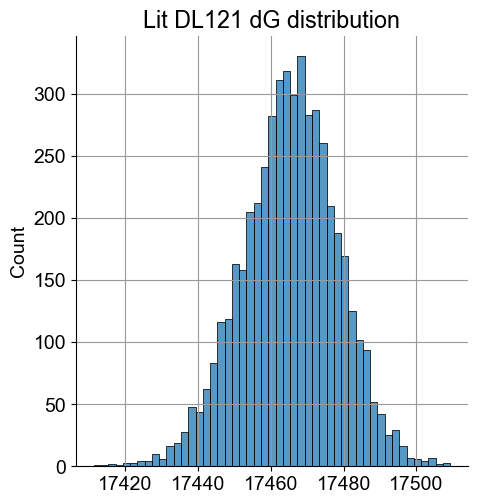

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -192.30523630582593

std:  14.200612038408739

variance:  201.6573822653992
The 95% confidence interval:  [-220.57797015 -165.1744674 ]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


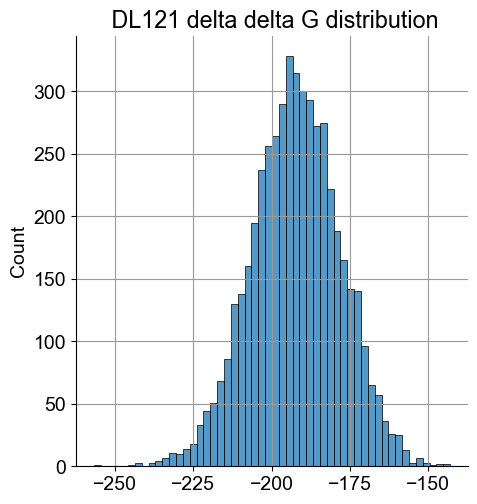

Intercept, x-Slope : Intercept    17353.786112
x               17.329113
dtype: float64
Intercept, x-Slope : Intercept    17071.833572
x               22.449482
dtype: float64


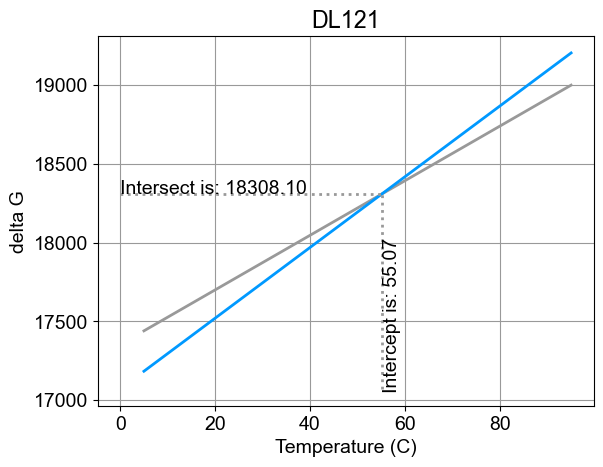

Intercept, x-Slope: 
 Intercept   -281.044115
x              5.103520
dtype: float64
Y Intercept is: 55.07


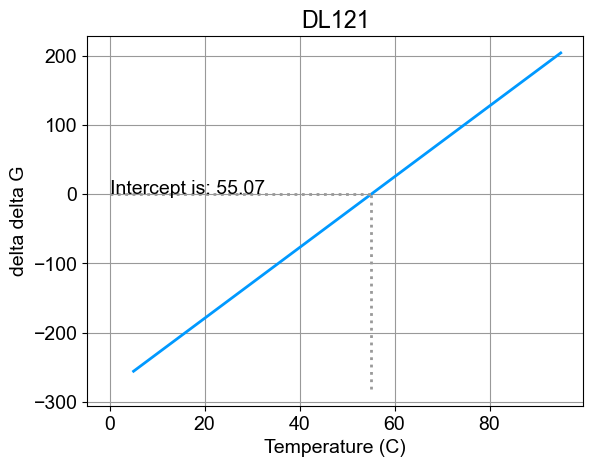

######################## A9N ########################
Intercept, x-Slope : Intercept      11.739937
x           -5271.220282
dtype: float64


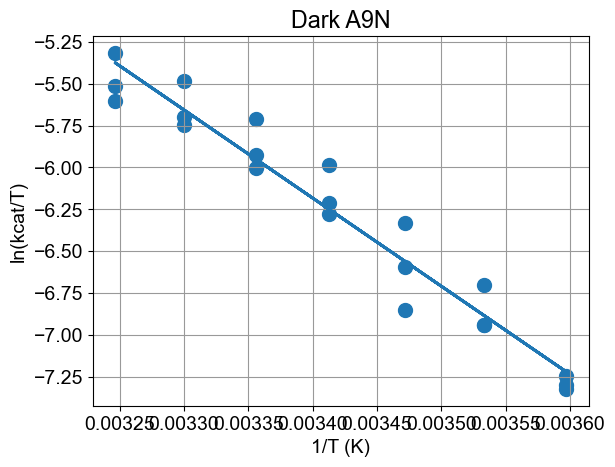

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     341.1
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.35e-13
Time:                        12:34:22   Log-Likelihood:                 10.713
No. Observations:                  21   AIC:                            -17.43
Df Residuals:                      19   BIC:                            -15.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7399      0.976     12.031      0.0

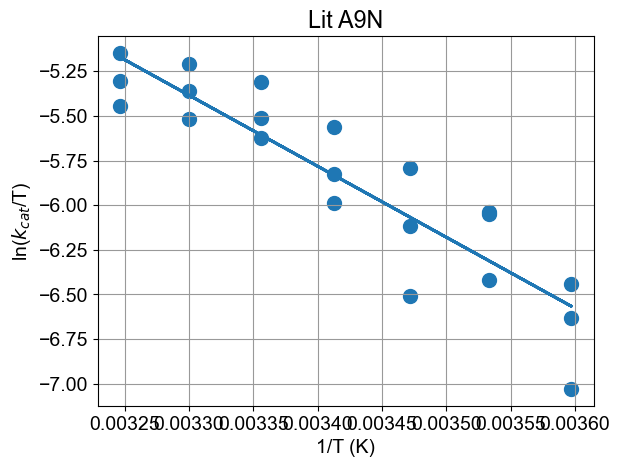

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     85.89
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.77e-08
Time:                        12:34:22   Log-Likelihood:                 2.1495
No. Observations:                  21   AIC:                           -0.2991
Df Residuals:                      19   BIC:                             1.790
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7406      1.467      5.276      0.0

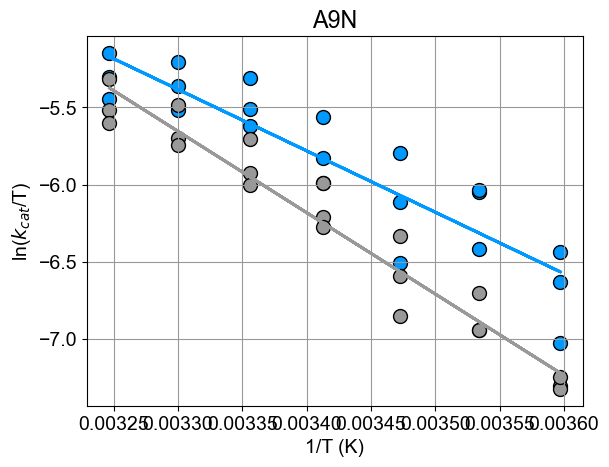

dark slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


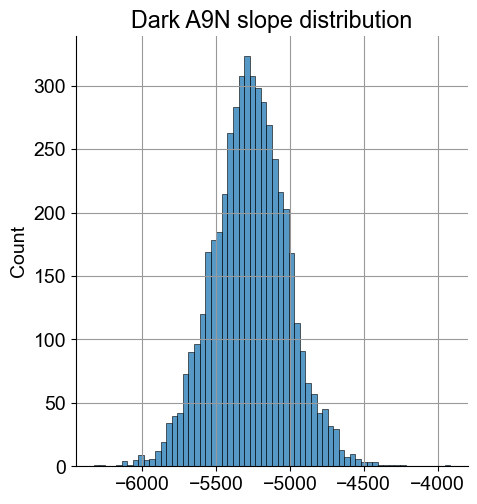


Mean:  -5270.048351813047

std:  253.4208792201457

variance:  64222.142024711684
The 95% confidence interval:  [-5770.0878348  -4761.71163198]
dark intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


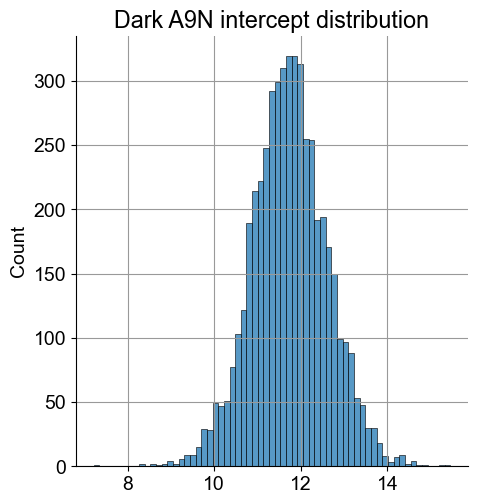


Mean:  11.738830091716176

std:  0.8688073034204794

variance:  0.754826130476765
The 95% confidence interval:  [10.00166127 13.45125698]
lit slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


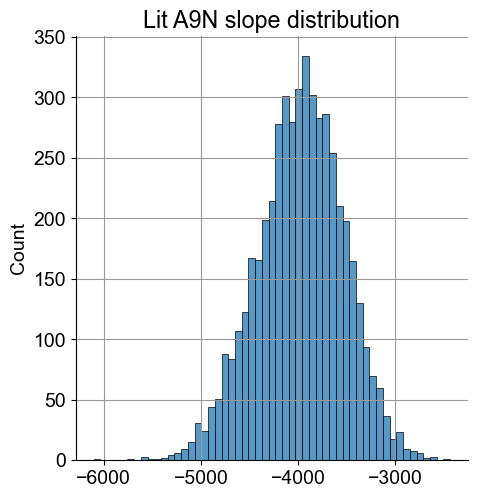


Mean:  -3975.0889837257296

std:  445.6741448748991

variance:  198625.44340997256
The 95% confidence interval:  [-4877.05650969 -3141.53844153]
lit intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


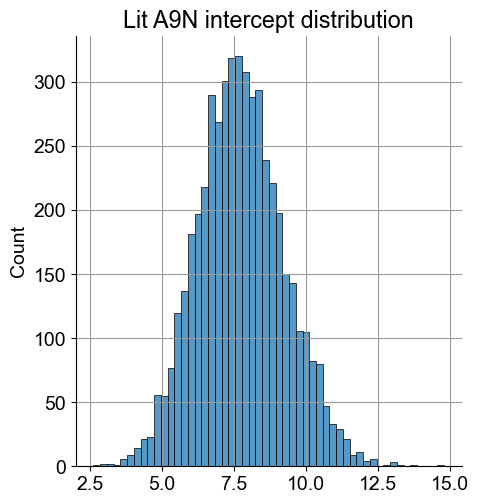


Mean:  7.737572291659697

std:  1.5049656421178406

variance:  2.2649215839551644
The 95% confidence interval:  [ 4.9216835  10.79112602]
dark enthalpy

Mean:  10.472662527965973

std:  0.503599050414777

variance:  0.25361200357866515
The 95% confidence interval:  [ 9.46249363 11.46634312]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


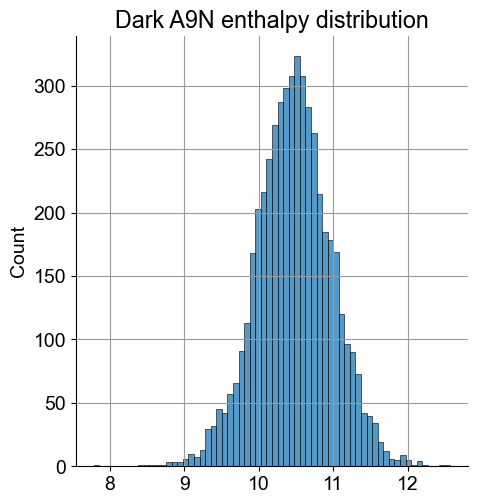

lit enthalpy

Mean:  7.89931375693602

std:  0.8856455586615098

variance:  0.7843680555768578
The 95% confidence interval:  [6.24287857 9.69170747]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


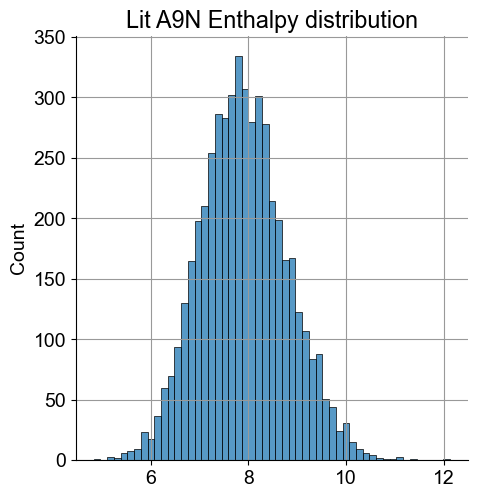

p value that enthalpy are different:  0.0
dark entropy

Mean:  -23.88890093205179

std:  1.7264975732954324

variance:  2.9807938705950168
The 95% confidence interval:  [-27.3410102  -20.48595894]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


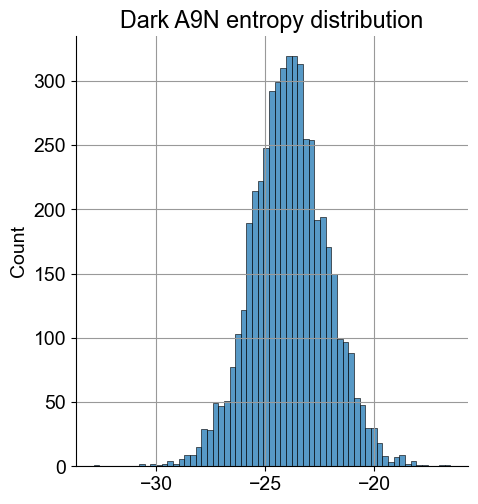

lit entropy

Mean:  -31.840217472243868

std:  2.9906741331247044

variance:  8.944131770541201
The 95% confidence interval:  [-37.43596366 -25.77218249]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


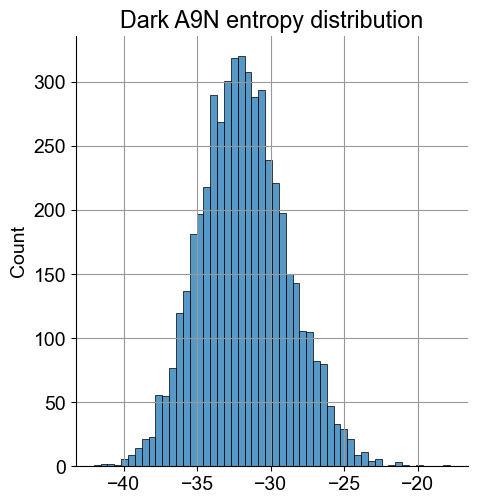

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.4816472094485156

std:  0.015903809688887677

variance:  0.0002529311626203576
The 95% confidence interval:  [0.45222968 0.51442052]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


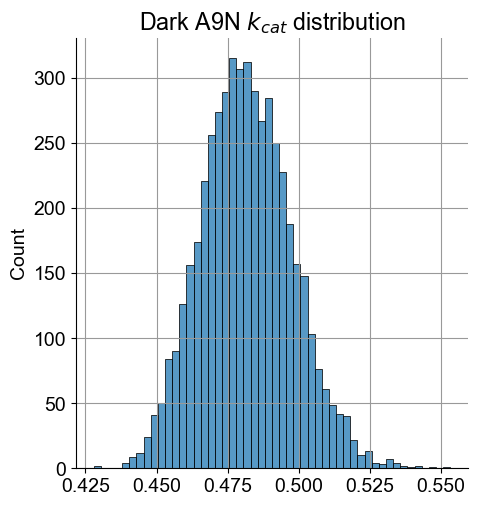

Kcat_lit

kcat lit mean:  0.7609534595674655

std:  0.04116923334925037

variance:  0.001694905774565029
The 95% confidence interval:  [0.68056081 0.84276568]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


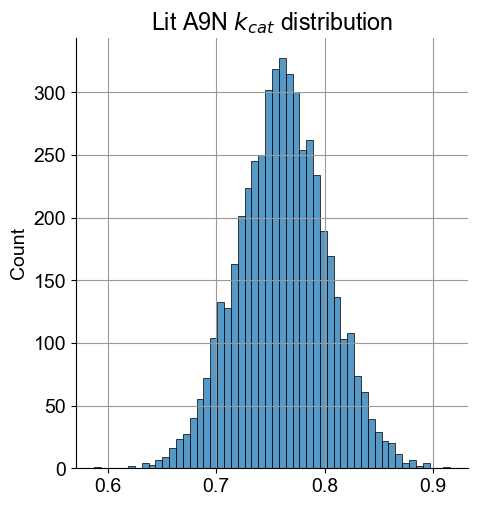

delta G dark

Mean:  17412.388248727017

std:  19.012496226576296

variance:  361.47501276557796
The 95% confidence interval:  [17374.07265012 17448.45603607]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


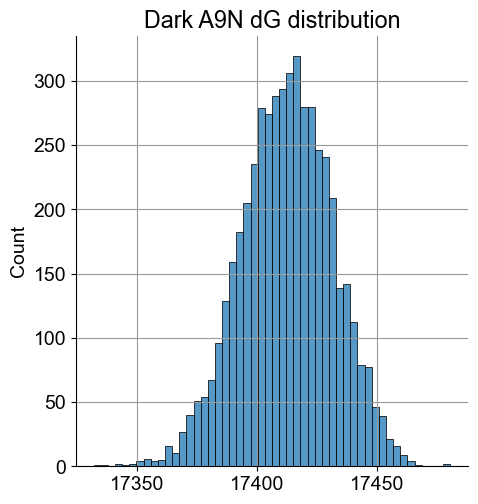

delta G lit

Mean:  17148.89693262286

std:  31.34381995386487

variance:  982.4350493002976
The 95% confidence interval:  [17089.09822692 17212.50499569]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


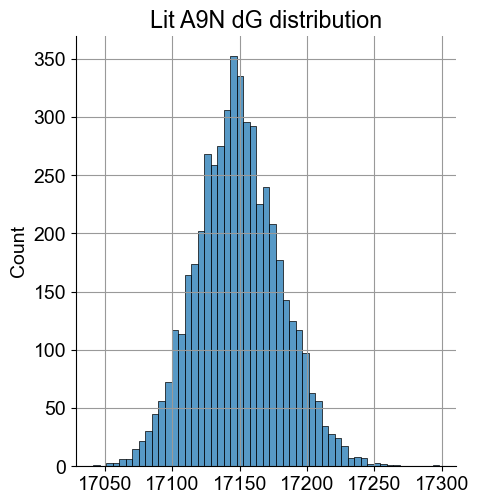

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -263.49131610415543

std:  36.84446474835719

variance:  1357.5145825929358
The 95% confidence interval:  [-334.687128   -189.23213534]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


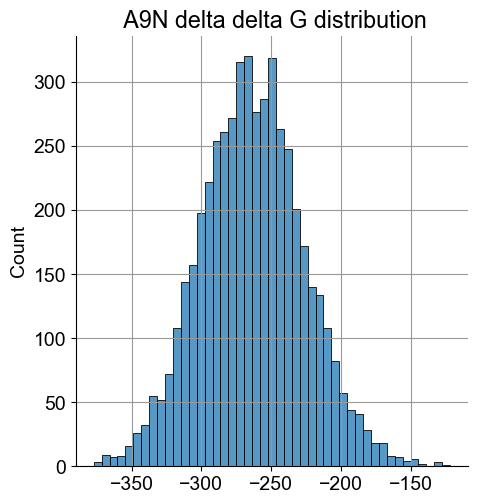

Intercept, x-Slope : Intercept    16993.737697
x               23.890301
dtype: float64
Intercept, x-Slope : Intercept    16591.184106
x               31.840054
dtype: float64


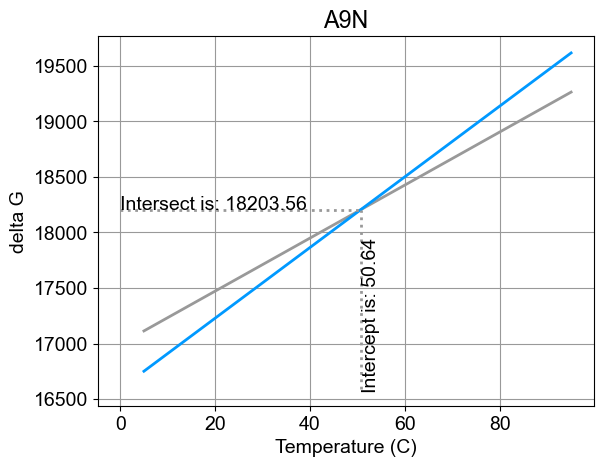

Intercept, x-Slope: 
 Intercept   -401.825609
x              7.934974
dtype: float64
Y Intercept is: 50.64


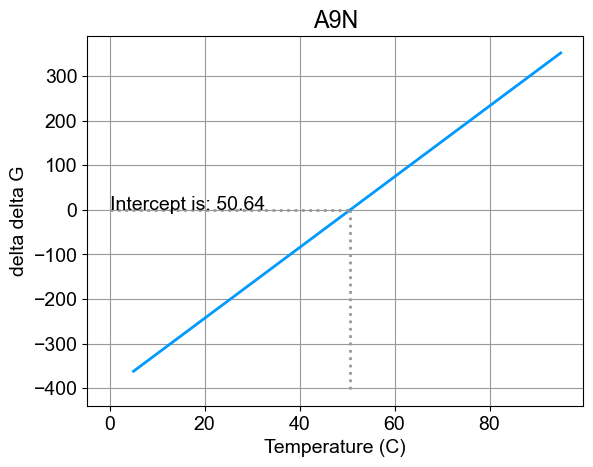

######################## M16A ########################
Intercept, x-Slope : Intercept      14.764333
x           -6518.040632
dtype: float64


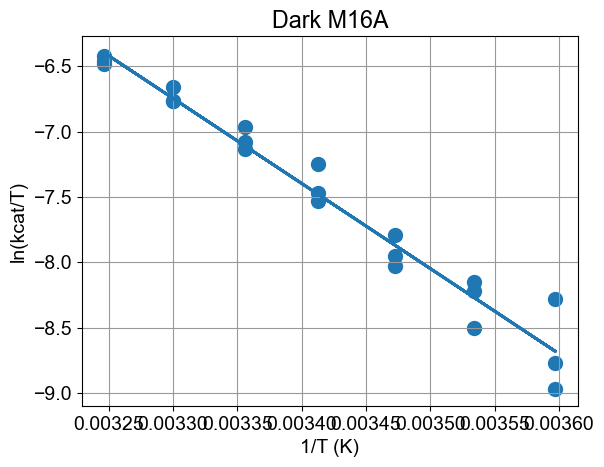

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     508.0
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           3.59e-15
Time:                        12:34:47   Log-Likelihood:                 10.438
No. Observations:                  21   AIC:                            -16.88
Df Residuals:                      19   BIC:                            -14.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.7643      0.989     14.933      0.0

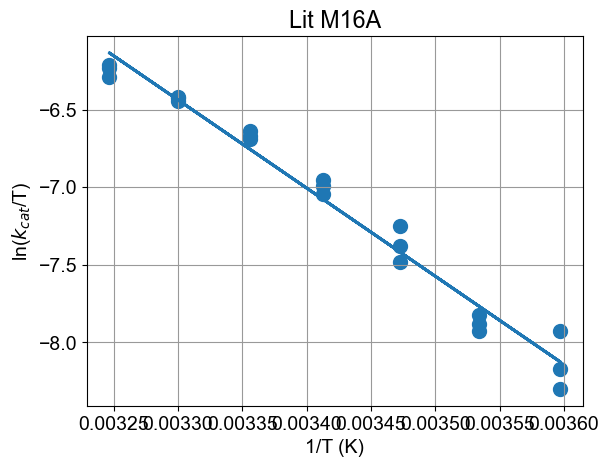

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     731.7
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.24e-16
Time:                        12:34:47   Log-Likelihood:                 17.154
No. Observations:                  21   AIC:                            -30.31
Df Residuals:                      19   BIC:                            -28.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3108      0.718     17.144      0.0

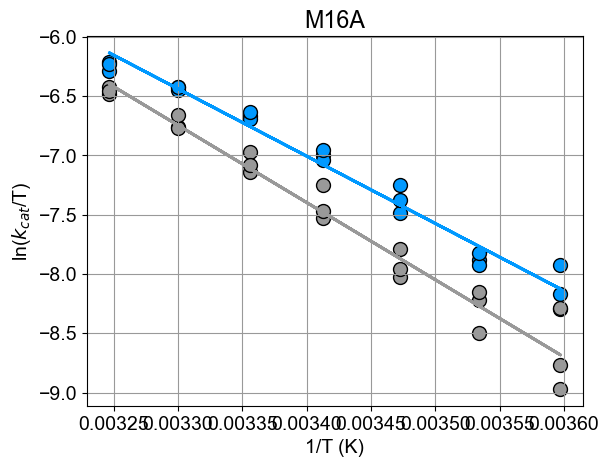

dark slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


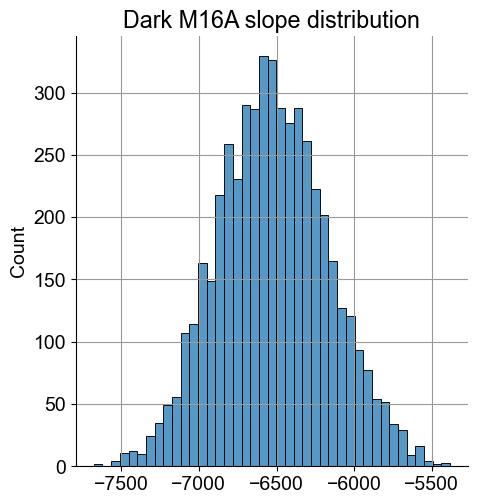


Mean:  -6523.059545609656

std:  353.991794013573

variance:  125310.19022894787
The 95% confidence interval:  [-7190.66429182 -5810.09592245]
dark intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


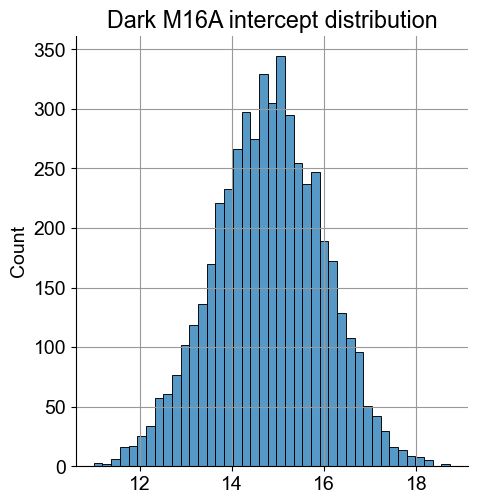


Mean:  14.783240290562299

std:  1.1860574415289782

variance:  1.4067322546062655
The 95% confidence interval:  [12.39498322 17.0399184 ]
lit slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


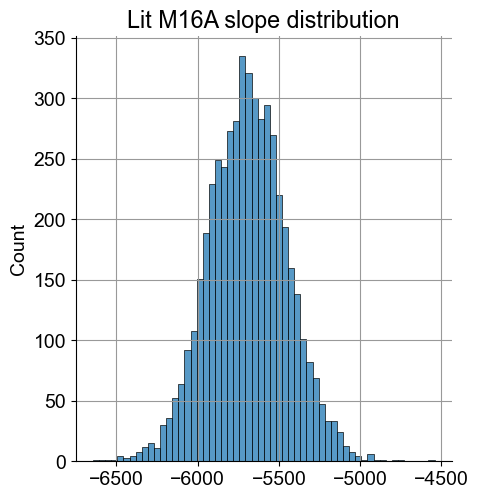


Mean:  -5692.449890665105

std:  239.58268456842256

variance:  57399.86274501226
The 95% confidence interval:  [-6157.17988525 -5216.46244343]
lit intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


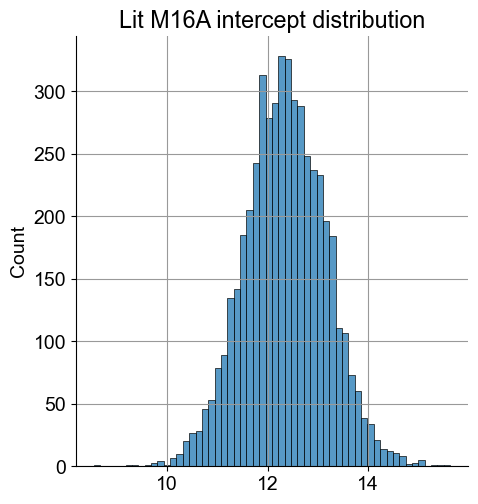


Mean:  12.35081060178146

std:  0.8107441100148488

variance:  0.6573060119237693
The 95% confidence interval:  [10.74609067 13.9417631 ]
dark enthalpy

Mean:  12.962651708403225

std:  0.7034540005876797

variance:  0.49484753094281125
The 95% confidence interval:  [11.54584736 14.2893187 ]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


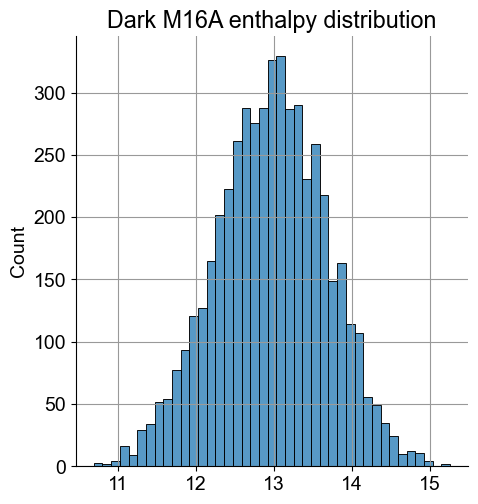

lit enthalpy

Mean:  11.312060664829222

std:  0.47609973107097203

variance:  0.22667095392585188
The 95% confidence interval:  [10.36617638 12.23557409]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


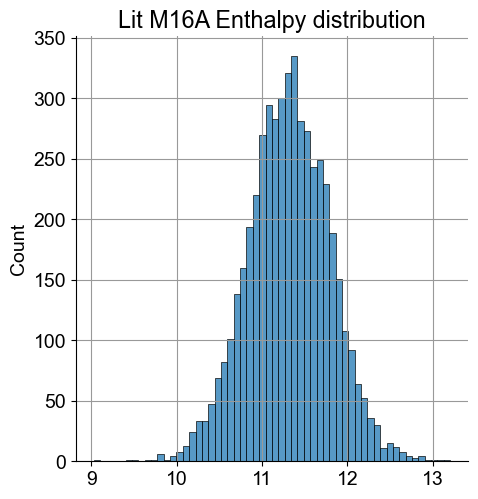

p value that enthalpy are different:  0.0
dark entropy

Mean:  -17.839036019855197

std:  2.356938398799033

variance:  5.555158615733348
The 95% confidence interval:  [-22.58499064 -13.35455567]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


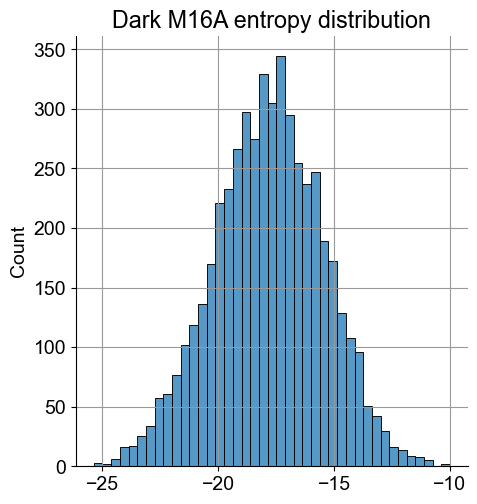

lit entropy

Mean:  -22.67277065624487

std:  1.611114148089477

variance:  2.5956887981740815
The 95% confidence interval:  [-25.86167694 -19.51122309]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


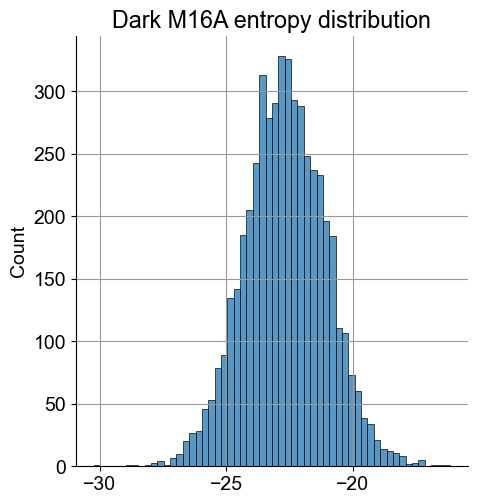

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.1354457594144096

std:  0.005378479671456611

variance:  2.8928043576272017e-05
The 95% confidence interval:  [0.12574892 0.146619  ]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


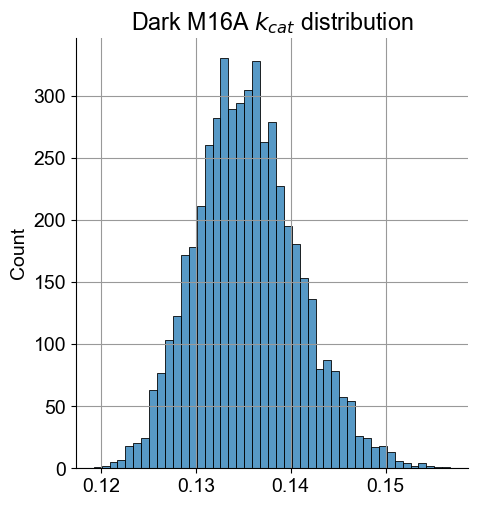

Kcat_lit

kcat lit mean:  0.20746463795356984

std:  0.005591646775649347

variance:  3.126651366362975e-05
The 95% confidence interval:  [0.1969041  0.21899559]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


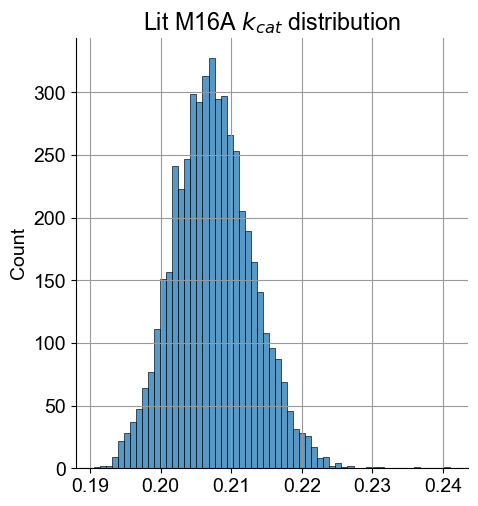

delta G dark

Mean:  18144.891672171158

std:  22.832070454321293

variance:  521.3034412310914
The 95% confidence interval:  [18098.68010173 18187.32194662]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


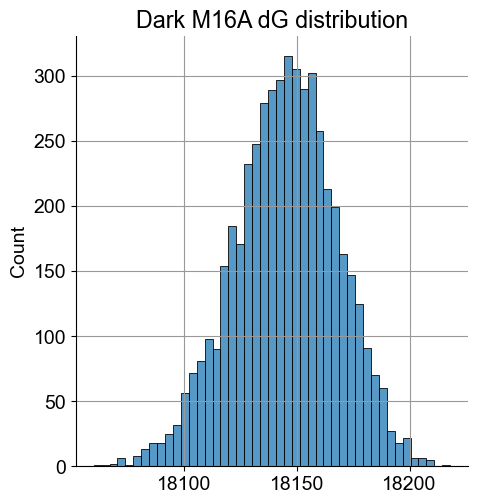

delta G lit

Mean:  17898.500540468358

std:  15.515665673700587

variance:  240.7358812980507
The 95% confidence interval:  [17867.06606139 17928.4512912 ]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


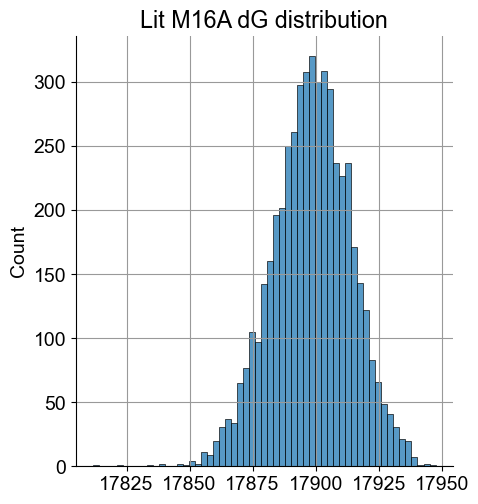

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -246.39113170280183

std:  28.013391352670954

variance:  784.7500950778998
The 95% confidence interval:  [-300.07182497 -190.69370068]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


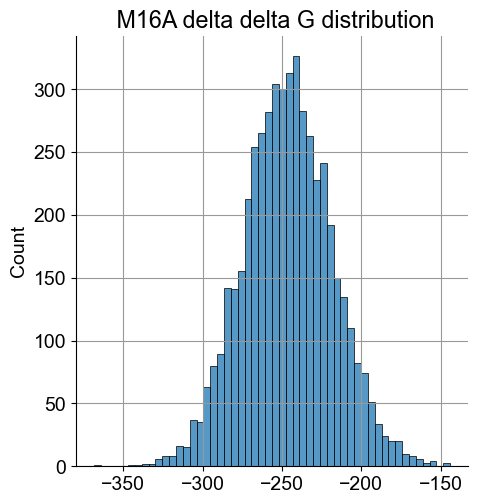

Intercept, x-Slope : Intercept    17832.190954
x               17.839258
dtype: float64
Intercept, x-Slope : Intercept    17501.262621
x               22.671890
dtype: float64


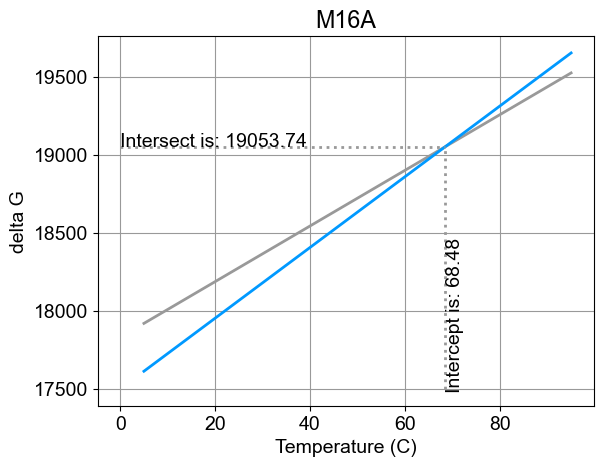

Intercept, x-Slope: 
 Intercept   -330.018634
x              4.819494
dtype: float64
Y Intercept is: 68.48


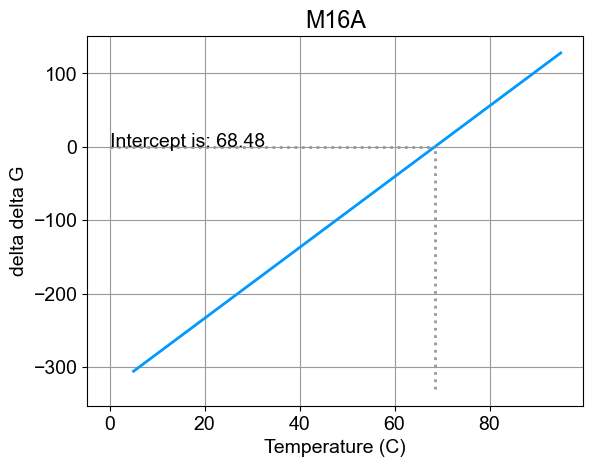

######################## M16P ########################
Intercept, x-Slope : Intercept      13.63022
x           -6628.94769
dtype: float64


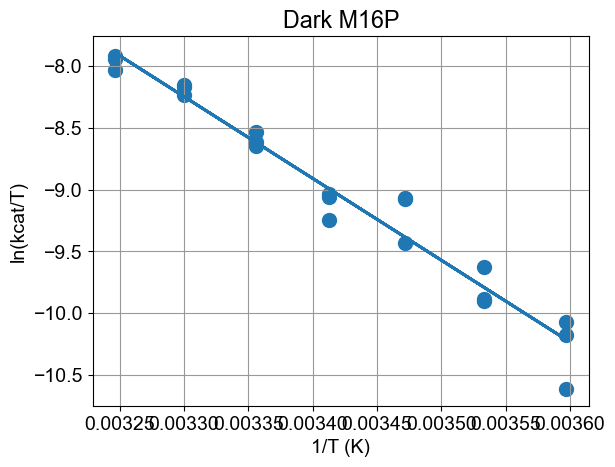

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     441.2
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.30e-14
Time:                        12:35:12   Log-Likelihood:                 8.6033
No. Observations:                  21   AIC:                            -13.21
Df Residuals:                      19   BIC:                            -11.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6302      1.079     12.632      0.0

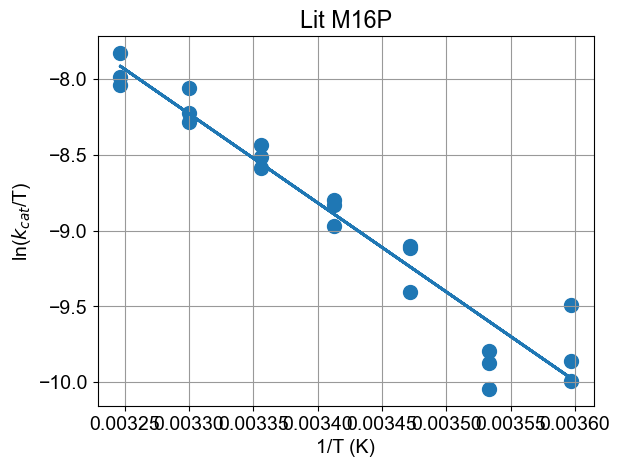

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     264.1
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.33e-12
Time:                        12:35:12   Log-Likelihood:                 5.7487
No. Observations:                  21   AIC:                            -7.497
Df Residuals:                      19   BIC:                            -5.408
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1613      1.236      9.030      0.0

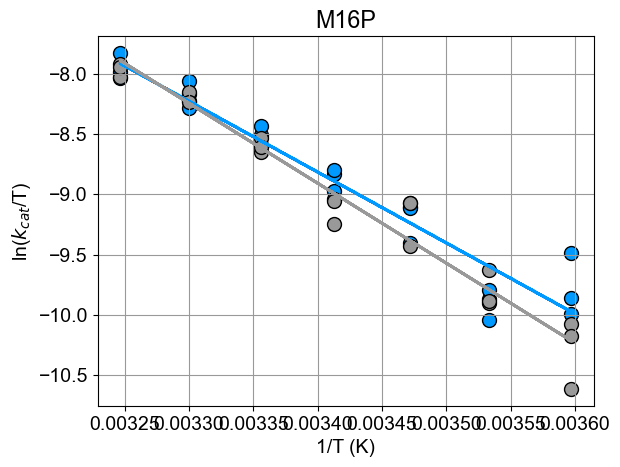

dark slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


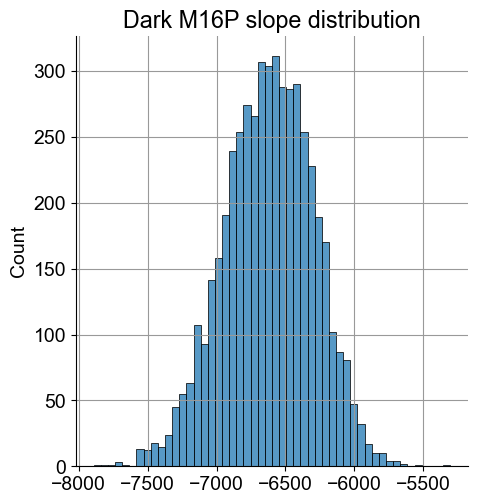


Mean:  -6622.101752274468

std:  324.96914539397306

variance:  105604.9454580892
The 95% confidence interval:  [-7282.24942278 -6026.06943337]
dark intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


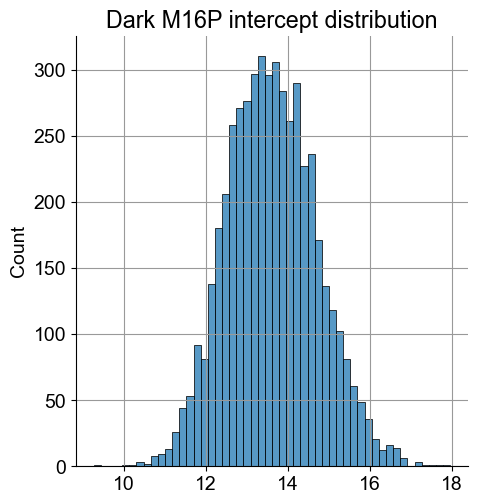


Mean:  13.609088132343244

std:  1.088745098670599

variance:  1.1853658898792525
The 95% confidence interval:  [11.61658023 15.81135426]
lit slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


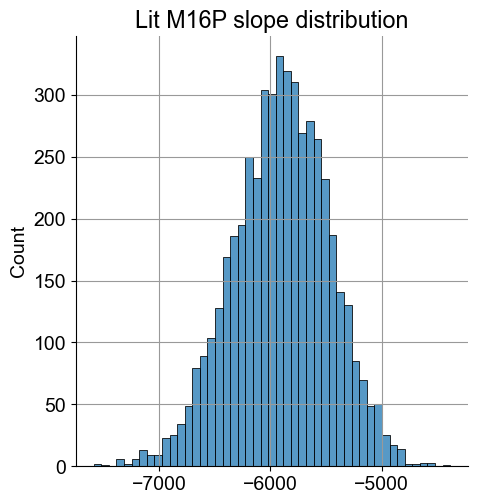


Mean:  -5906.723125716305

std:  433.03967503061904

variance:  187523.36015062415
The 95% confidence interval:  [-6778.89554247 -5081.4184636 ]
lit intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


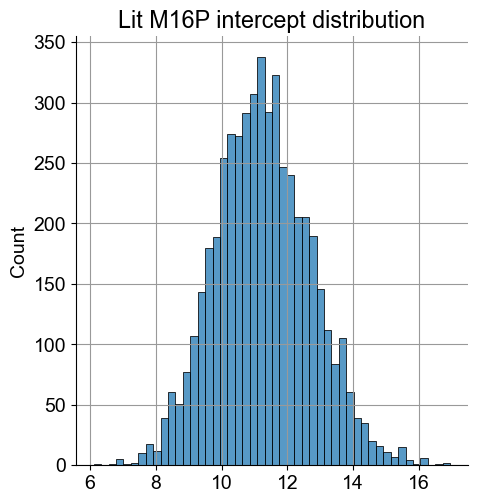


Mean:  11.26549148383545

std:  1.4501354538284628

variance:  2.102892834450282
The 95% confidence interval:  [ 8.50220804 14.19835007]
dark enthalpy

Mean:  13.159468803272722

std:  0.6457800696537744

variance:  0.41703189836203375
The 95% confidence interval:  [11.97503084 14.47131707]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


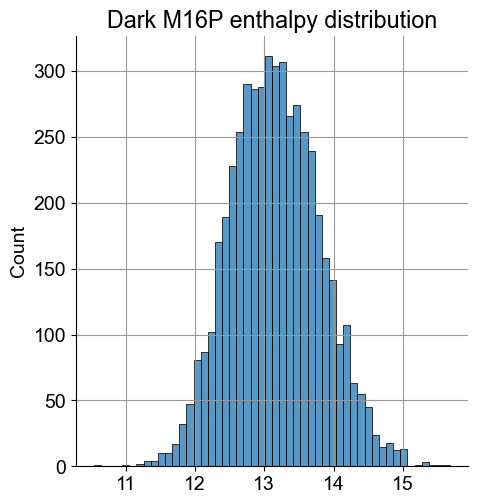

lit enthalpy

Mean:  11.737865350035717

std:  0.8605382863812874

variance:  0.7405261423280425
The 95% confidence interval:  [10.09781641 13.47105009]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


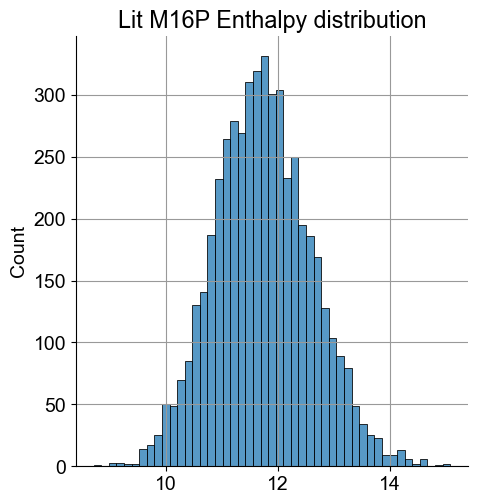

p value that enthalpy are different:  0.0
dark entropy

Mean:  -20.172316188960423

std:  2.1635588966525447

variance:  4.680987099284377
The 95% confidence interval:  [-24.13183637 -15.79596356]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


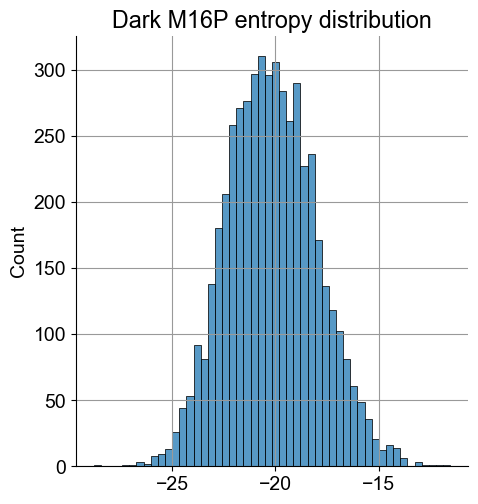

lit entropy

Mean:  -24.829521429411486

std:  2.881715349453974

variance:  8.30428335527864
The 95% confidence interval:  [-30.32073005 -19.00133236]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


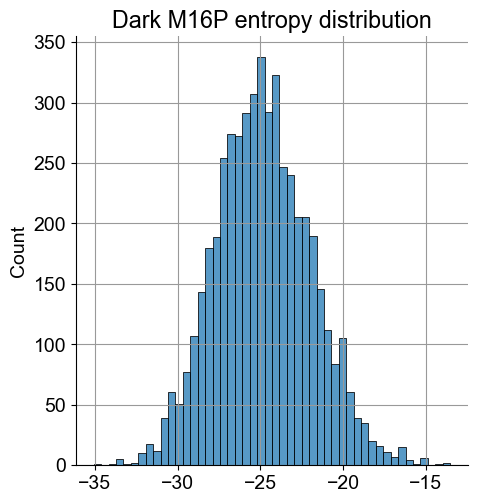

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.029771815432872255

std:  0.0012396970112761106

variance:  1.5368486797669211e-06
The 95% confidence interval:  [0.02745295 0.03229925]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


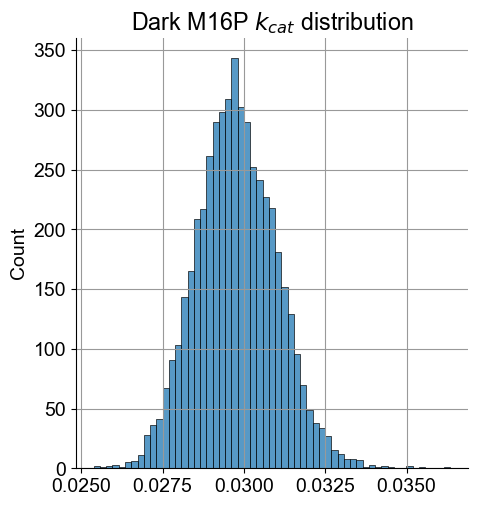

Kcat_lit

kcat lit mean:  0.03354563815129416

std:  0.0016631153167552767

variance:  2.7659525568260042e-06
The 95% confidence interval:  [0.03035993 0.0368752 ]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


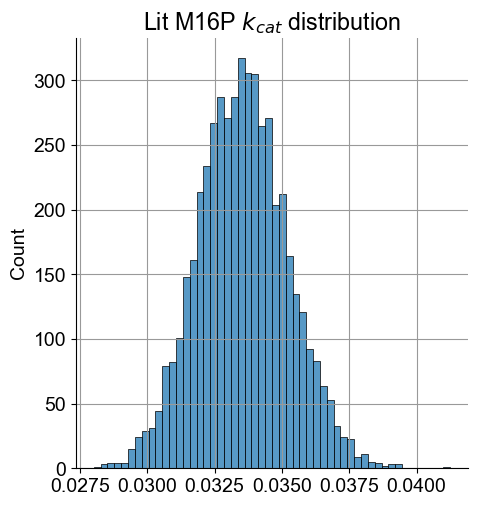

delta G dark

Mean:  19019.526656165726

std:  23.98933305506966

variance:  575.4881004270578
The 95% confidence interval:  [18971.98962023 19065.83876991]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


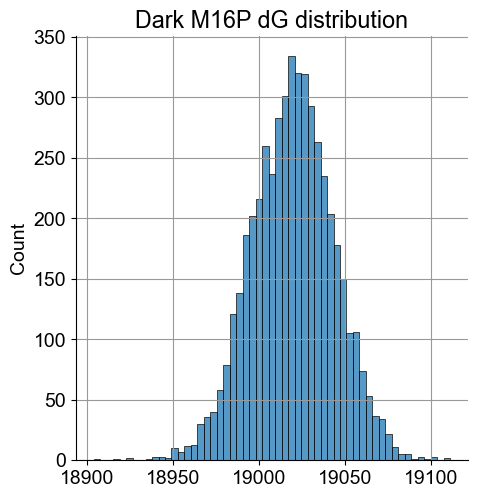

delta G lit

Mean:  18950.841325279755

std:  28.622907481651268

variance:  819.2708327031681
The 95% confidence interval:  [18895.50238914 19007.73522181]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


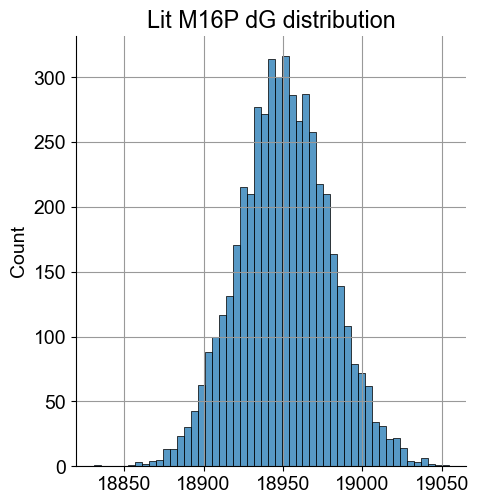

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -68.68533088597265

std:  37.64840488531956

variance:  1417.4023904089536
The 95% confidence interval:  [-142.0208429     5.66857933]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


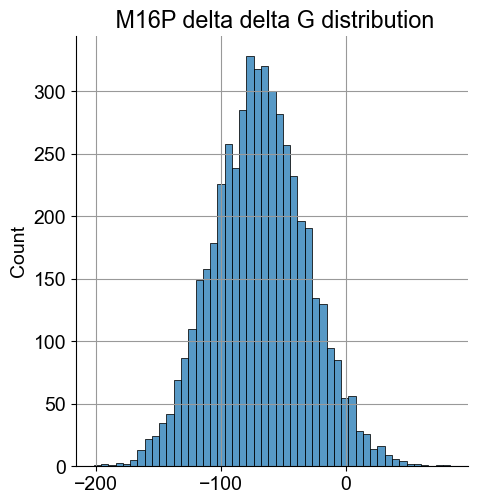

Intercept, x-Slope : Intercept    18666.004937
x               20.172209
dtype: float64
Intercept, x-Slope : Intercept    18515.810639
x               24.829941
dtype: float64


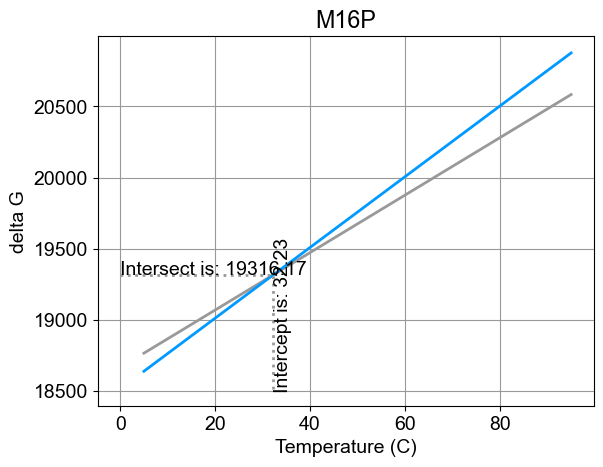

Intercept, x-Slope: 
 Intercept   -149.652174
x              4.642714
dtype: float64
Y Intercept is: 32.23


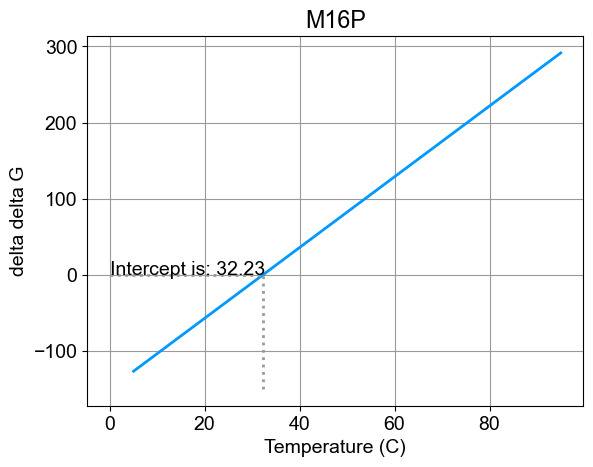

######################## G86K ########################
Intercept, x-Slope : Intercept       7.607439
x           -4178.284915
dtype: float64


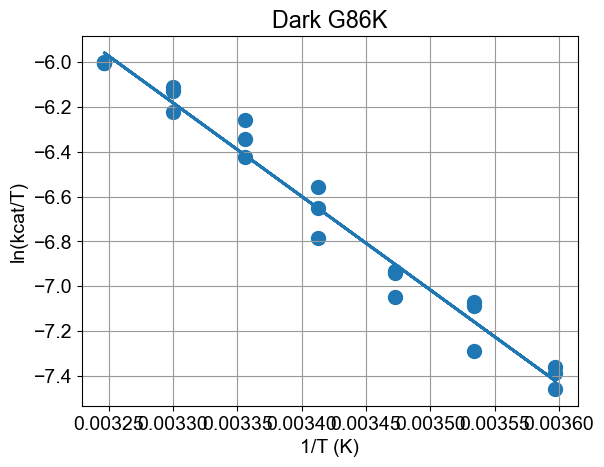

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     721.2
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.42e-16
Time:                        12:35:38   Log-Likelihood:                 23.456
No. Observations:                  21   AIC:                            -42.91
Df Residuals:                      19   BIC:                            -40.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6074      0.532     14.302      0.0

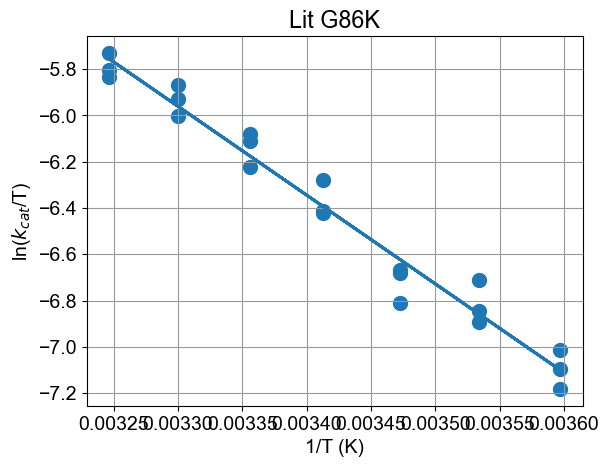

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     625.5
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           5.28e-16
Time:                        12:35:38   Log-Likelihood:                 23.746
No. Observations:                  21   AIC:                            -43.49
Df Residuals:                      19   BIC:                            -41.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7044      0.525     12.779      0.0

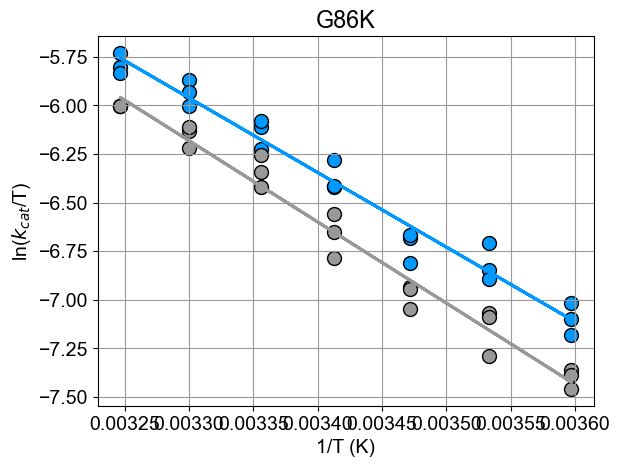

dark slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


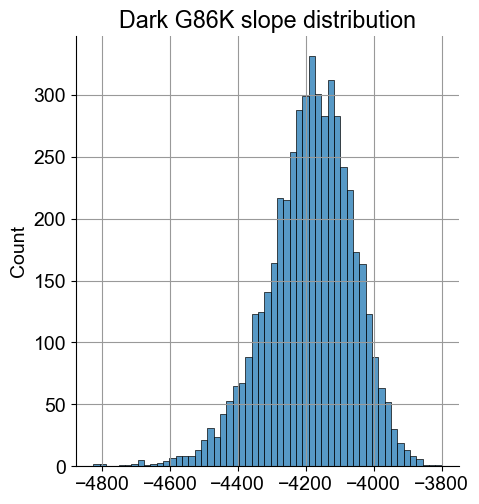


Mean:  -4188.034434926224

std:  126.94264876248255

variance:  16114.436074835014
The 95% confidence interval:  [-4466.68382161 -3966.32525859]
dark intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


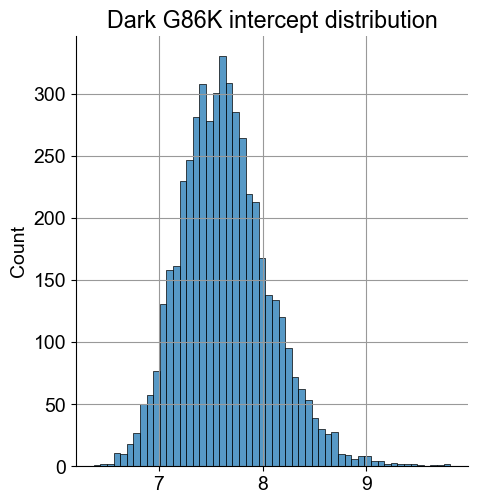


Mean:  7.641119649568015

std:  0.43129437341313676

variance:  0.18601483653783024
The 95% confidence interval:  [6.8887932  8.58769749]
lit slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


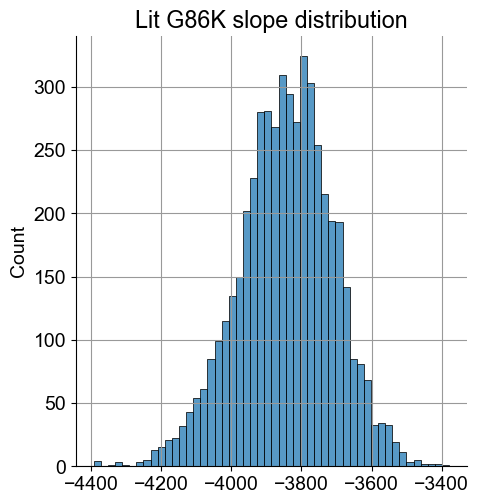


Mean:  -3844.9979569175957

std:  134.80371149569848

variance:  18172.040633015513
The 95% confidence interval:  [-4126.40820502 -3589.69197637]
lit intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


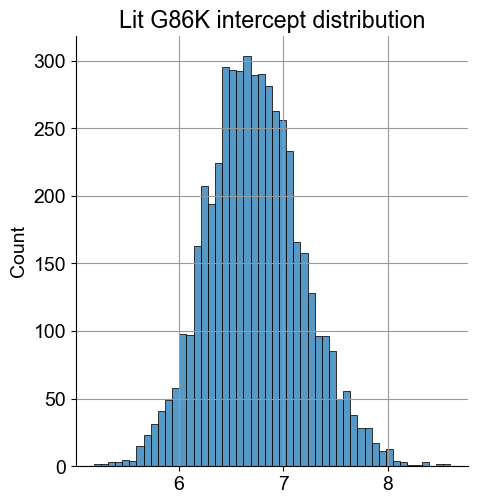


Mean:  6.728634133000491

std:  0.4561512524724167

variance:  0.20807396513215445
The 95% confidence interval:  [5.86463199 7.68119086]
dark enthalpy

Mean:  8.322479864419833

std:  0.2522609722239524

variance:  0.06363559810737368
The 95% confidence interval:  [7.88189845 8.87621311]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


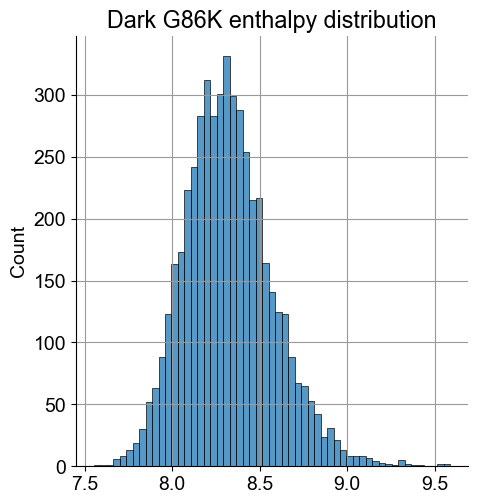

lit enthalpy

Mean:  7.640796314451936

std:  0.2678825095648419

variance:  0.0717610389307576
The 95% confidence interval:  [7.13345118 8.20001596]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


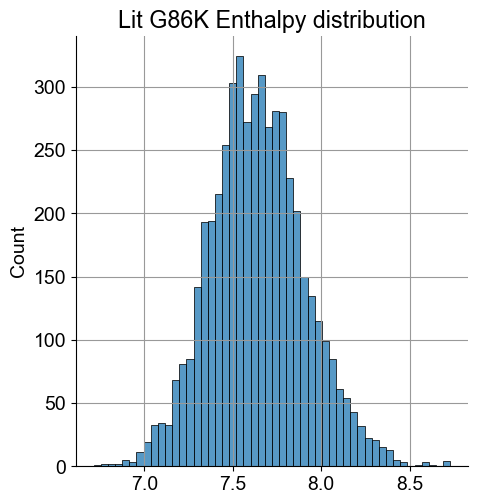

p value that enthalpy are different:  0.0
dark entropy

Mean:  -32.03188857336561

std:  0.8570700155744139

variance:  0.7345690115967259
The 95% confidence interval:  [-33.5269149  -30.15084505]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


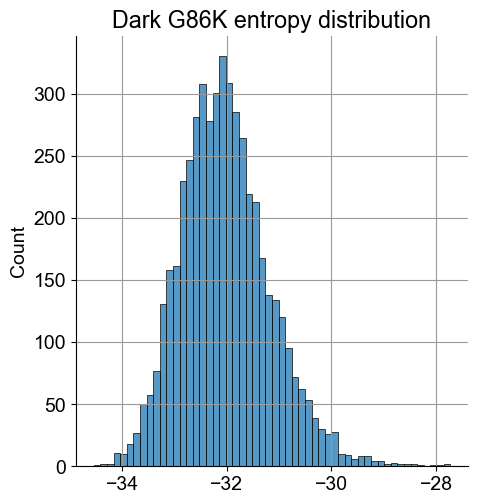

lit entropy

Mean:  -33.84518367783668

std:  0.9064657114975351

variance:  0.8216800861207324
The 95% confidence interval:  [-35.56213242 -31.9522589 ]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


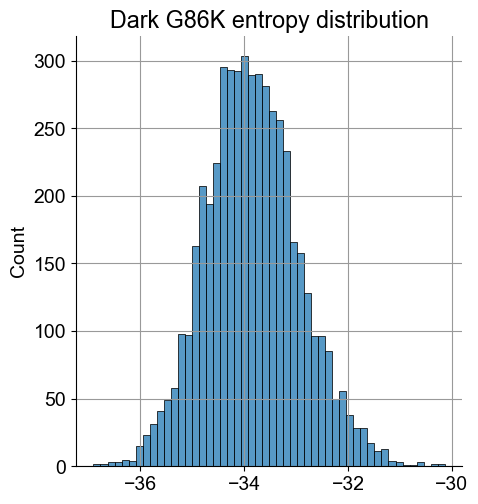

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.3315561498636694

std:  0.006258212376891483

variance:  3.916522215427774e-05
The 95% confidence interval:  [0.31929536 0.34367854]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


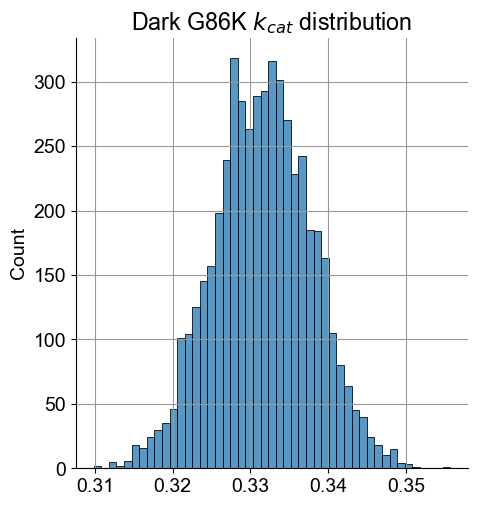

Kcat_lit

kcat lit mean:  0.43361659790245993

std:  0.008201767166421204

variance:  6.72689846521849e-05
The 95% confidence interval:  [0.41791775 0.44985161]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


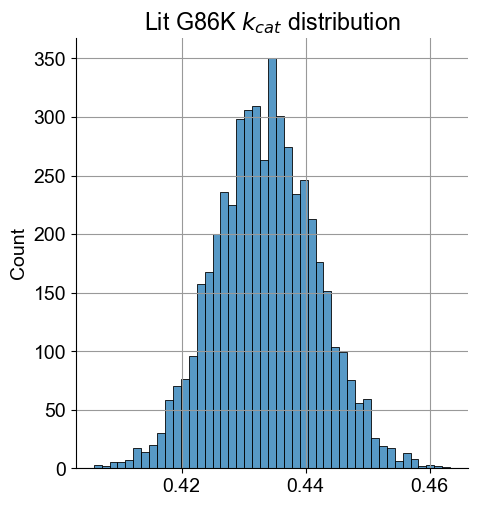

delta G dark

Mean:  17627.743494982547

std:  10.90346431898232

variance:  118.88553415532056
The 95% confidence interval:  [17606.91059989 17649.39293698]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


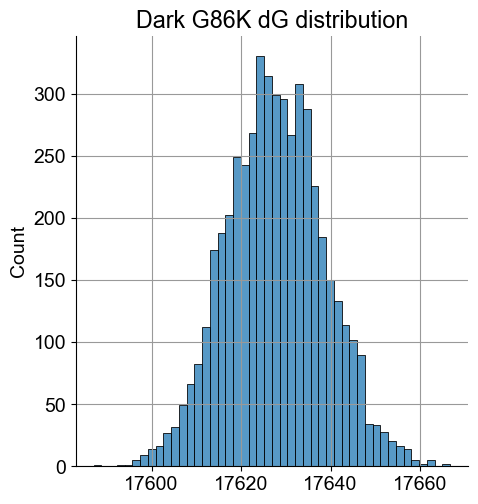

delta G lit

Mean:  17472.82217286349

std:  10.918330963469417

variance:  119.209951027855
The 95% confidence interval:  [17451.49971674 17494.00685797]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


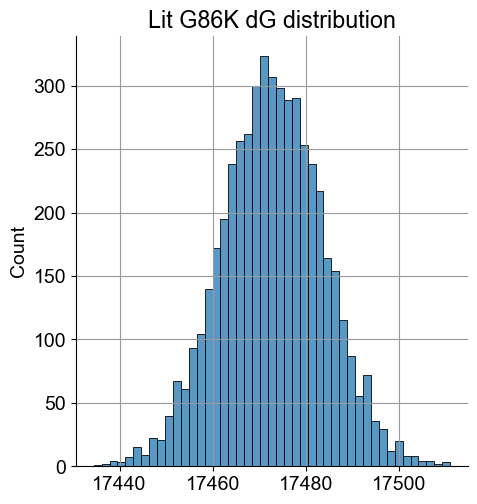

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -154.92132211905616

std:  15.35242664891221

variance:  235.6970040102298
The 95% confidence interval:  [-184.93338805 -125.51835055]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


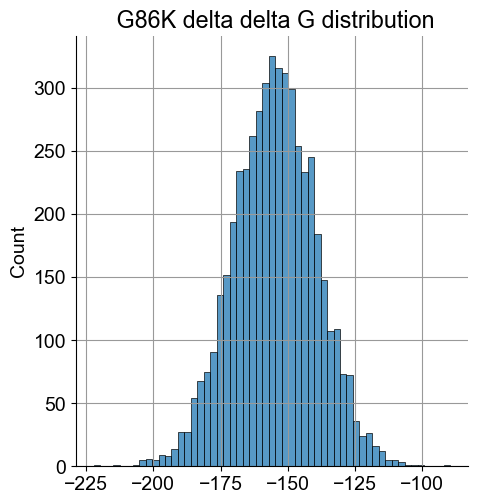

Intercept, x-Slope : Intercept    17066.647874
x               32.032537
dtype: float64
Intercept, x-Slope : Intercept    16880.026597
x               33.845182
dtype: float64


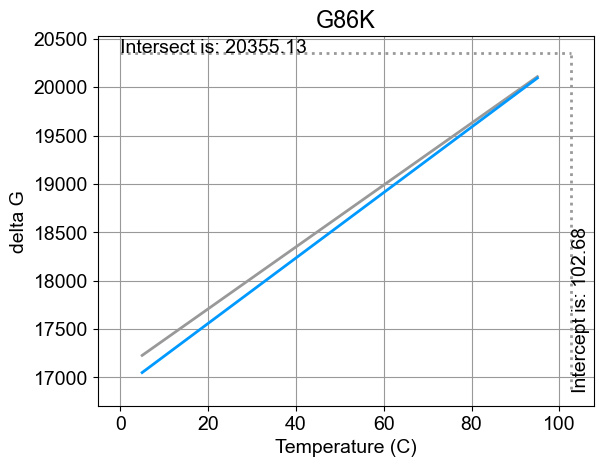

Intercept, x-Slope: 
 Intercept   -186.137124
x              1.812852
dtype: float64
Y Intercept is: 102.68


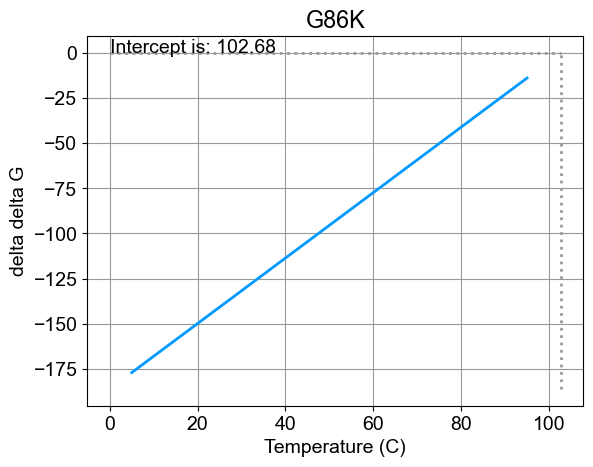

######################## D87A ########################
Intercept, x-Slope : Intercept      13.644569
x           -5864.364822
dtype: float64


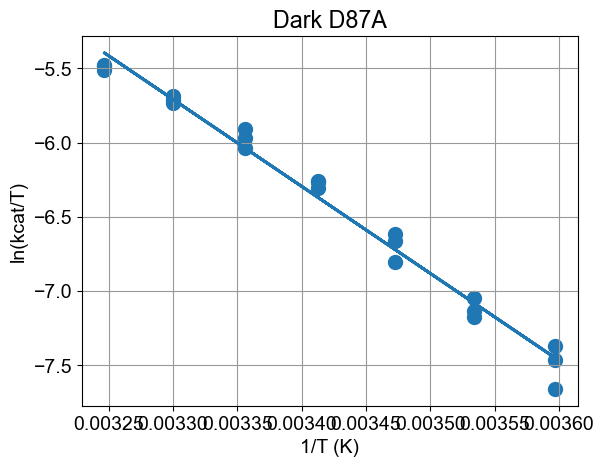

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1175.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.50e-18
Time:                        12:36:04   Log-Likelihood:                 21.464
No. Observations:                  21   AIC:                            -38.93
Df Residuals:                      19   BIC:                            -36.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6446      0.585     23.330      0.0

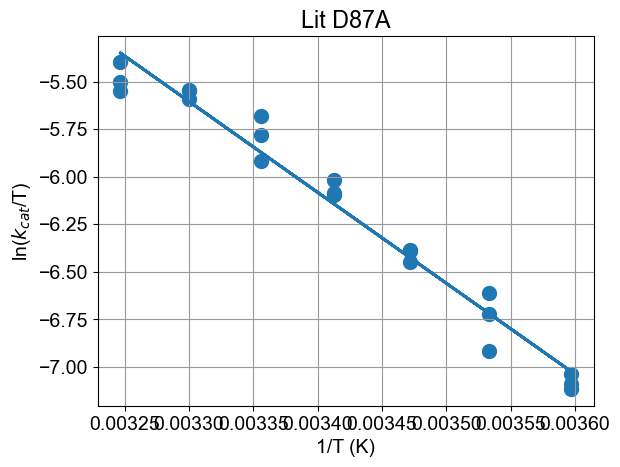

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     598.8
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           7.90e-16
Time:                        12:36:04   Log-Likelihood:                 18.678
No. Observations:                  21   AIC:                            -33.36
Df Residuals:                      19   BIC:                            -31.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1698      0.668     15.228      0.0

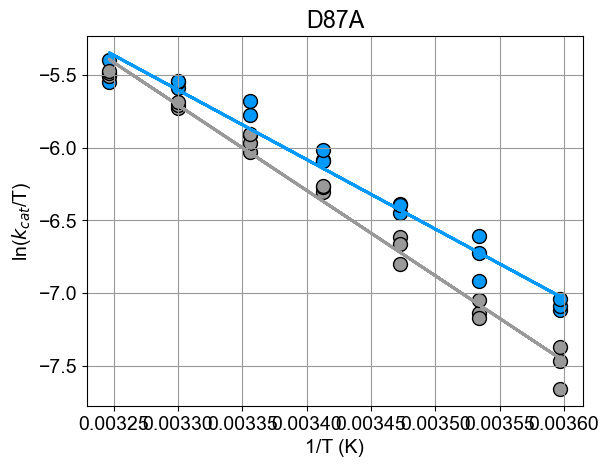

dark slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


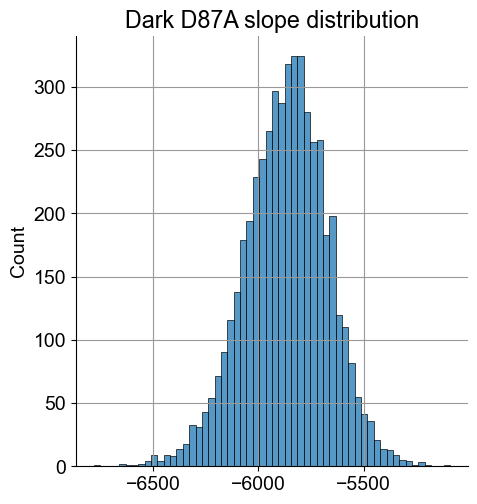


Mean:  -5869.0757874660985

std:  197.44874192069682

variance:  38986.00568606594
The 95% confidence interval:  [-6280.19483784 -5493.03500902]
dark intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


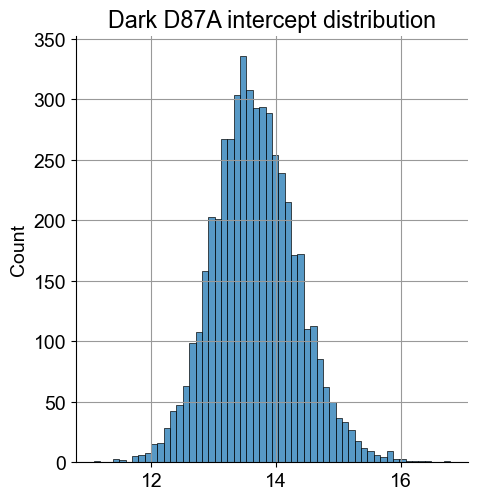


Mean:  13.663124373304136

std:  0.6700572933231844

variance:  0.4489767763355921
The 95% confidence interval:  [12.40005372 15.06939736]
lit slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


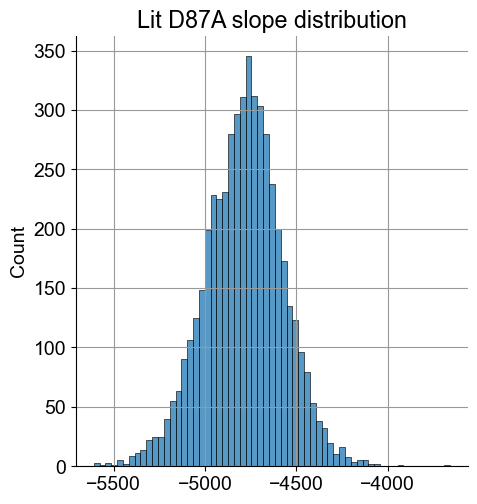


Mean:  -4787.209957722276

std:  213.4331930914403

variance:  45553.727913208044
The 95% confidence interval:  [-5222.2931056 -4379.1718082]
lit intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


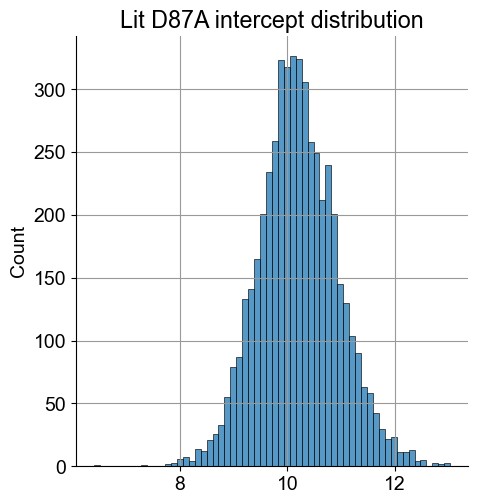


Mean:  10.197356344683108

std:  0.7345176689040162

variance:  0.53951620593219
The 95% confidence interval:  [ 8.80237539 11.70535529]
dark enthalpy

Mean:  11.663052399138413

std:  0.3923709808080829

variance:  0.15395498658029697
The 95% confidence interval:  [10.91578256 12.48002993]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


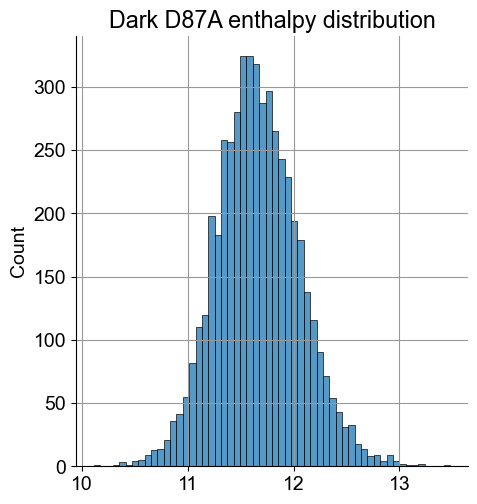

lit enthalpy

Mean:  9.513164014993492

std:  0.42413535024662075

variance:  0.17989079532882365
The 95% confidence interval:  [ 8.70230887 10.3777631 ]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


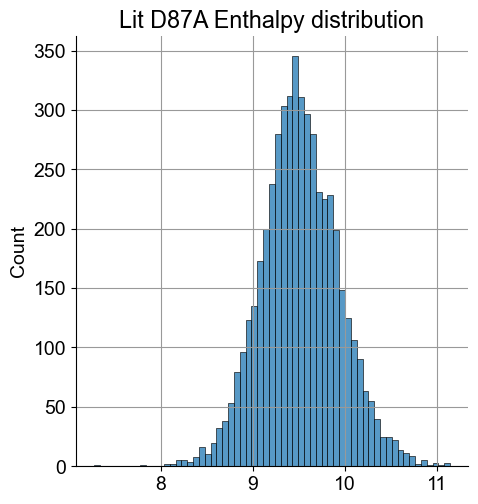

p value that enthalpy are different:  0.0
dark entropy

Mean:  -20.064935140802

std:  1.33154070682518

variance:  1.7730006539325
The 95% confidence interval:  [-22.57491451 -17.27038347]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


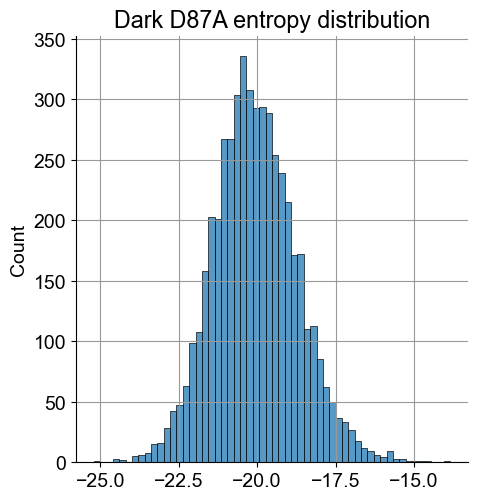

lit entropy

Mean:  -26.952124126738937

std:  1.459636639692996

variance:  2.1305391199342614
The 95% confidence interval:  [-29.72423623 -23.95542221]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


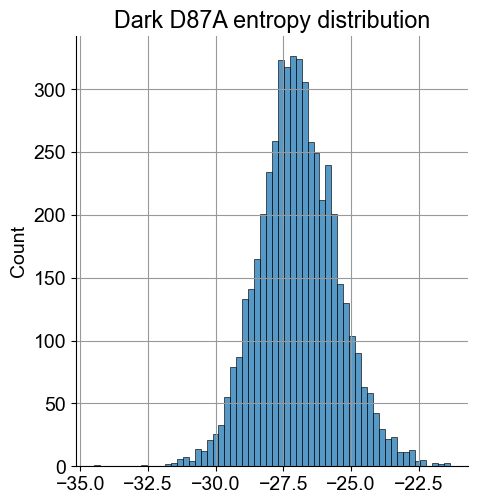

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.4195339831982616

std:  0.009157285491814137

variance:  8.385587757858967e-05
The 95% confidence interval:  [0.40170651 0.43799758]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


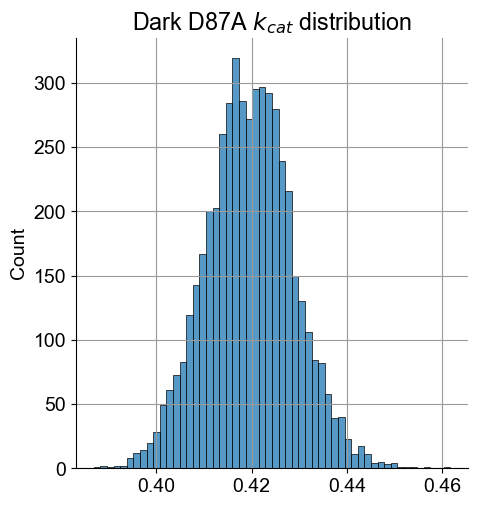

Kcat_lit

kcat lit mean:  0.5432294906966485

std:  0.011970473543066667

variance:  0.00014329223684525906
The 95% confidence interval:  [0.52004452 0.56694128]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


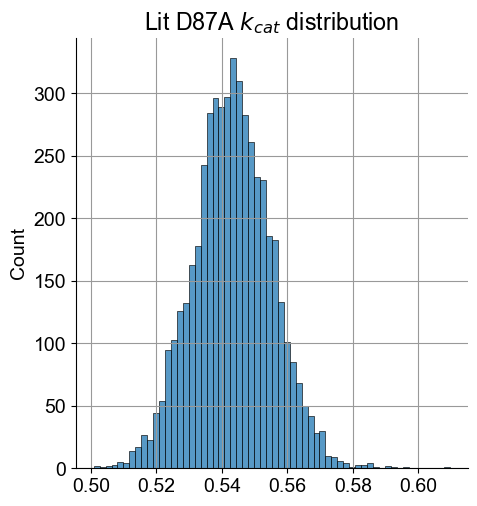

delta G dark

Mean:  17491.916057541395

std:  12.5969339061309

variance:  158.68274383543027
The 95% confidence interval:  [17466.91569218 17516.84583301]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


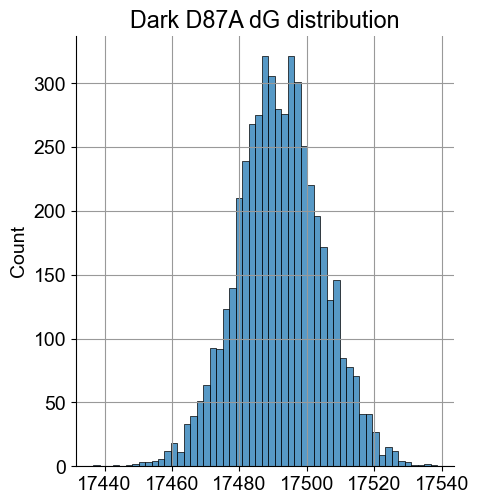

delta G lit

Mean:  17342.756073811157

std:  12.71272298415591

variance:  161.61332567188595
The 95% confidence interval:  [17317.9522975  17367.79564402]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


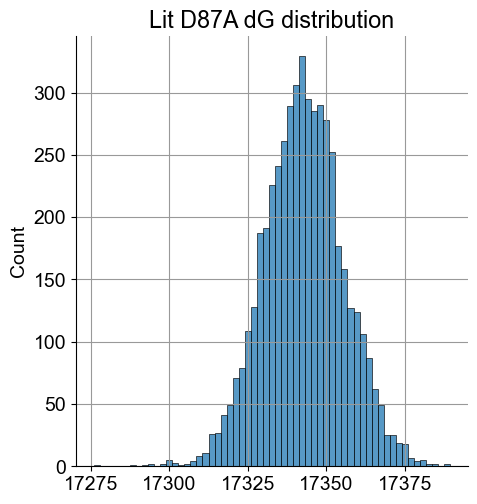

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -149.15998373023965

std:  18.00778783354356

variance:  324.2804226579195
The 95% confidence interval:  [-184.6341558  -114.37304055]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


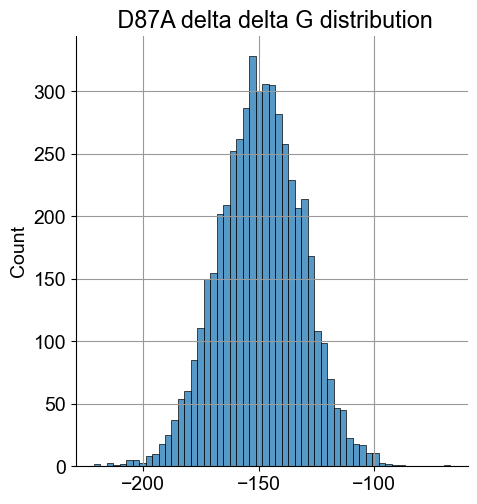

Intercept, x-Slope : Intercept    17140.351011
x               20.063529
dtype: float64
Intercept, x-Slope : Intercept    16870.569517
x               26.952126
dtype: float64


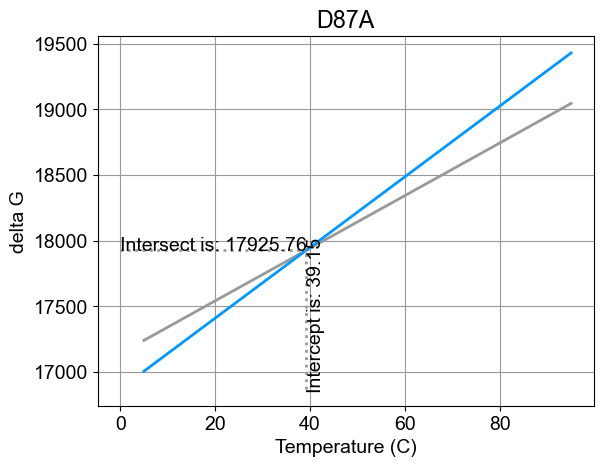

Intercept, x-Slope: 
 Intercept   -269.008441
x              6.871158
dtype: float64
Y Intercept is: 39.15


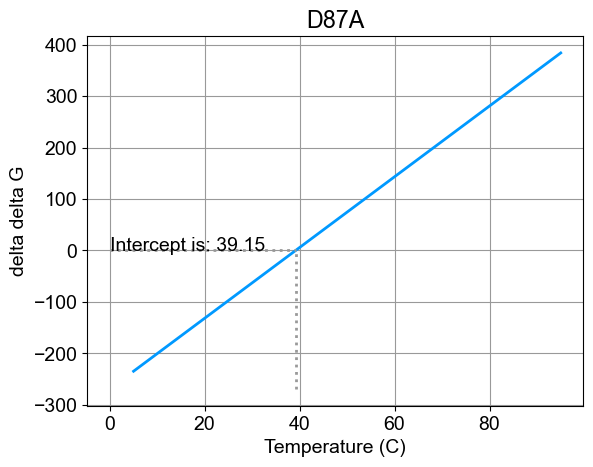

######################## R98M ########################
Intercept, x-Slope : Intercept       9.171813
x           -4505.474062
dtype: float64


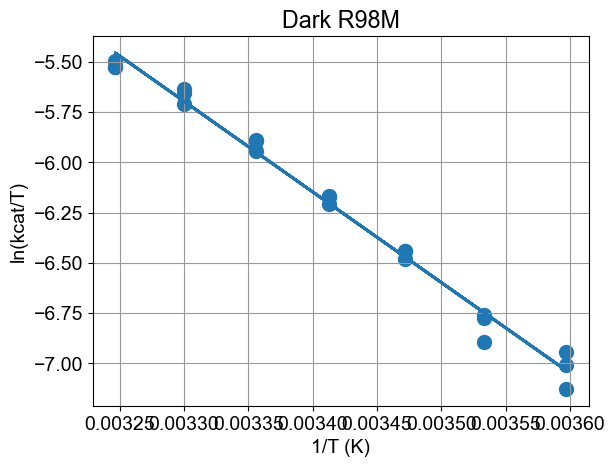

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1647.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           6.31e-20
Time:                        12:36:30   Log-Likelihood:                 30.546
No. Observations:                  21   AIC:                            -57.09
Df Residuals:                      19   BIC:                            -55.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1718      0.380     24.168      0.0

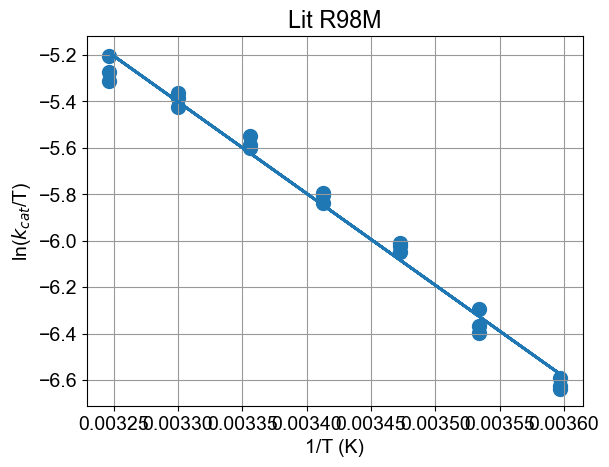

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1405.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           2.82e-19
Time:                        12:36:30   Log-Likelihood:                 31.642
No. Observations:                  21   AIC:                            -59.28
Df Residuals:                      19   BIC:                            -57.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6297      0.360     21.181      0.0

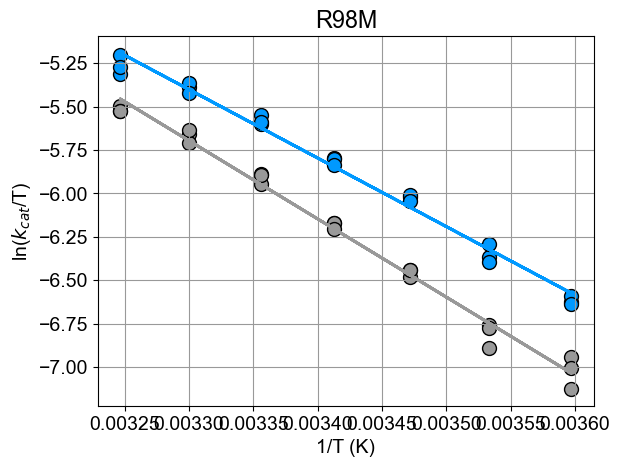

dark slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


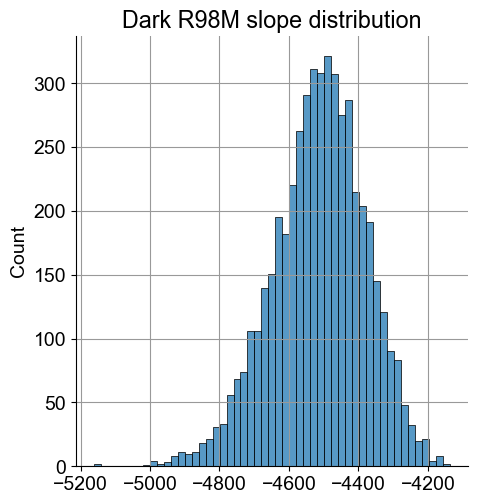


Mean:  -4513.929346921597

std:  134.2594978422541

variance:  18025.612760854234
The 95% confidence interval:  [-4797.87046014 -4272.88269403]
dark intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


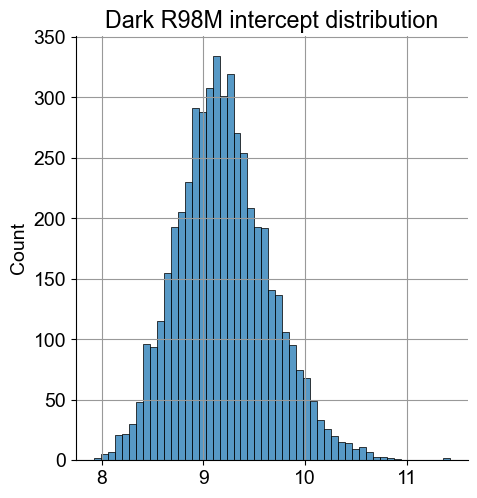


Mean:  9.201654388102376

std:  0.455966315346176

variance:  0.2079052807303684
The 95% confidence interval:  [ 8.38782723 10.15968237]
lit slopes


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


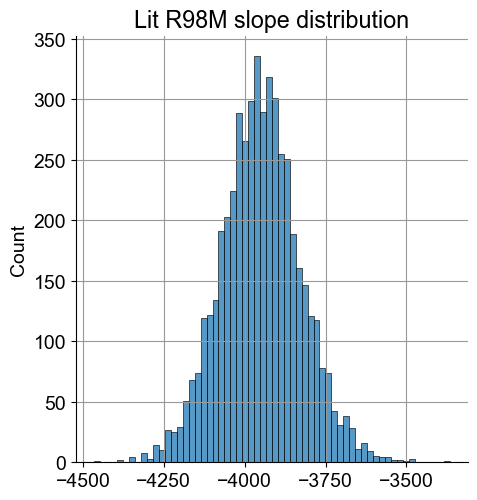


Mean:  -3950.801675071708

std:  123.59168748110642

variance:  15274.905214427477
The 95% confidence interval:  [-4189.08194564 -3697.62104496]
lit intercepts


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


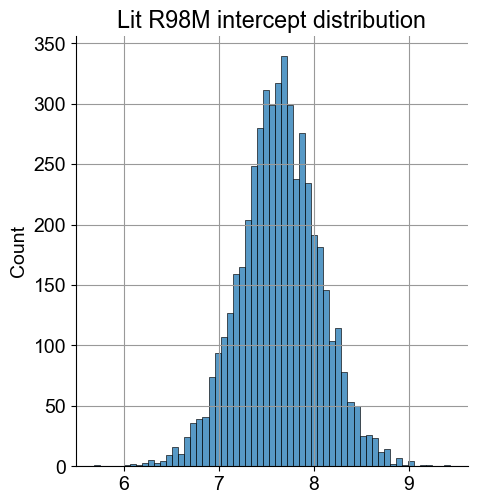


Mean:  7.638241577349556

std:  0.4245207724789828

variance:  0.1802178862661523
The 95% confidence interval:  [6.77849654 8.46950594]
dark enthalpy

Mean:  8.97009962140642

std:  0.26680104587510667

variance:  0.07118279808005078
The 95% confidence interval:  [8.49109069 9.53434861]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


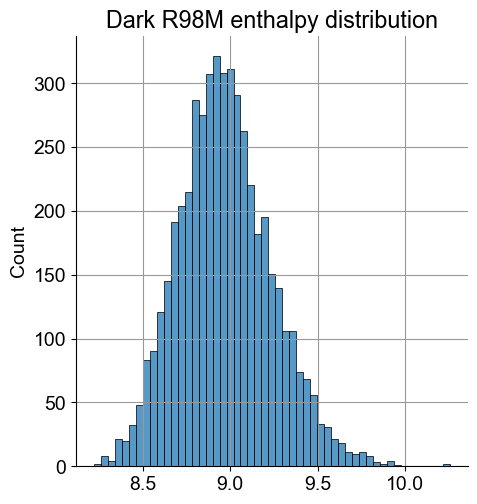

lit enthalpy

Mean:  7.851049913747824

std:  0.24560192769506126

variance:  0.0603203068875301
The 95% confidence interval:  [7.34792829 8.32456148]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


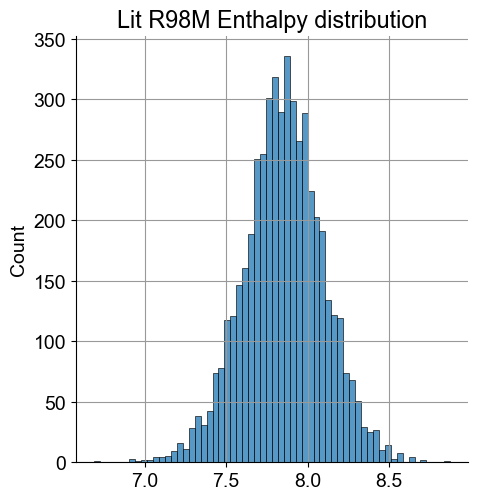

p value that enthalpy are different:  0.0
dark entropy

Mean:  -28.930787295193177

std:  0.9060982036526886

variance:  0.8210139546626292
The 95% confidence interval:  [-30.54802808 -27.02699002]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


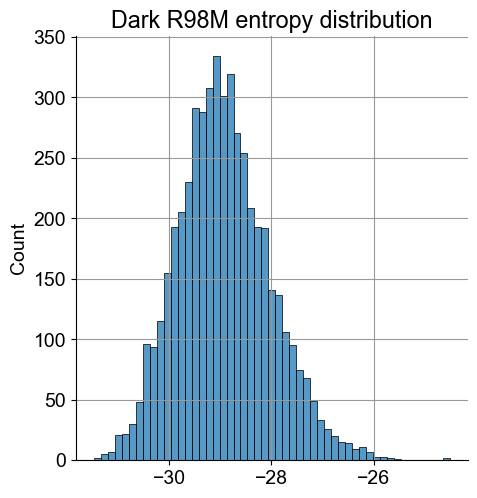

lit entropy

Mean:  -32.03760789073481

std:  0.8436094869517295

variance:  0.7116769664749604
The 95% confidence interval:  [-33.74609688 -30.3857158 ]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


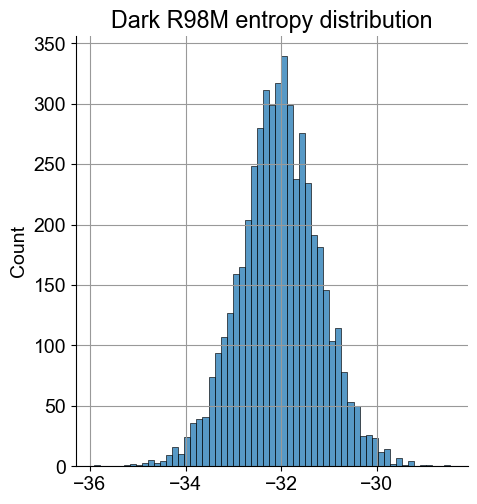

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.5140927501443375

std:  0.006946709594963308

variance:  4.8256774196755295e-05
The 95% confidence interval:  [0.50026068 0.52739772]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


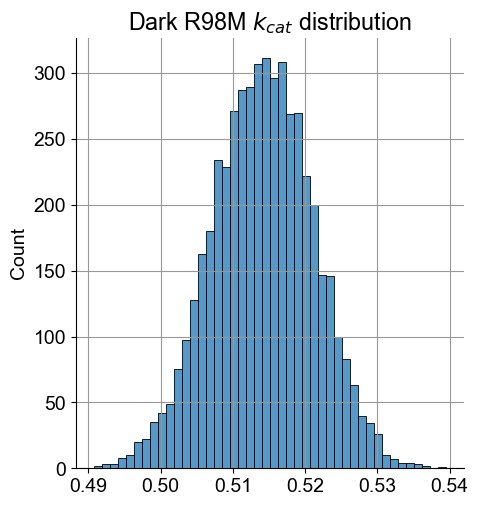

Kcat_lit

kcat lit mean:  0.748037157215156

std:  0.009209281925313659

variance:  8.481087357990886e-05
The 95% confidence interval:  [0.73015401 0.76642359]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


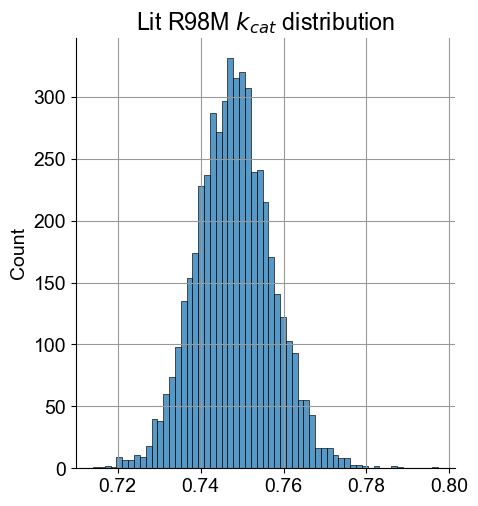

delta G dark

Mean:  17374.493330660036

std:  7.804714982555411

variance:  60.9135759589249
The 95% confidence interval:  [17359.69029039 17390.18562214]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


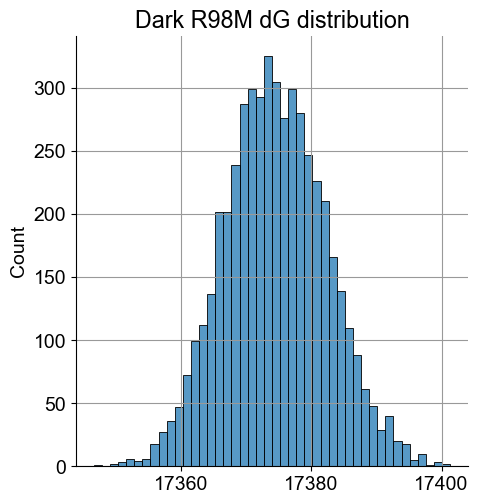

delta G lit

Mean:  17157.975006006287

std:  7.102649370295238

variance:  50.44762807735533
The 95% confidence interval:  [17143.91350813 17171.89990211]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


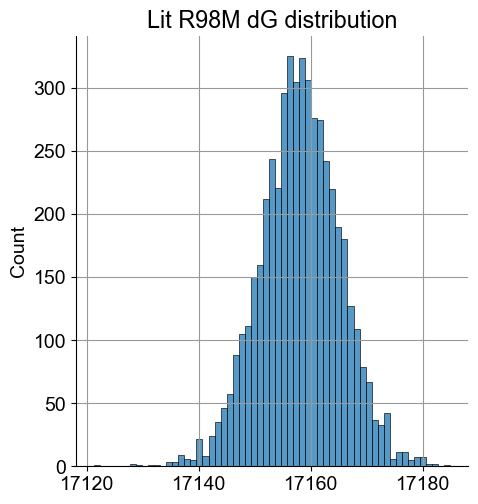

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -216.5183246537516

std:  10.487174768866286

variance:  109.98083463274564
The 95% confidence interval:  [-237.89685167 -196.80916613]


/Users/kimreynol/anaconda3/envs/pogo_pance/envs/dl121_thermo/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


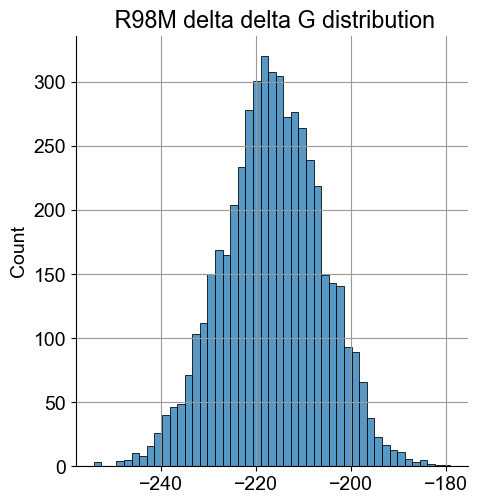

Intercept, x-Slope : Intercept    16867.690715
x               28.930801
dtype: float64
Intercept, x-Slope : Intercept    16596.788661
x               32.037633
dtype: float64


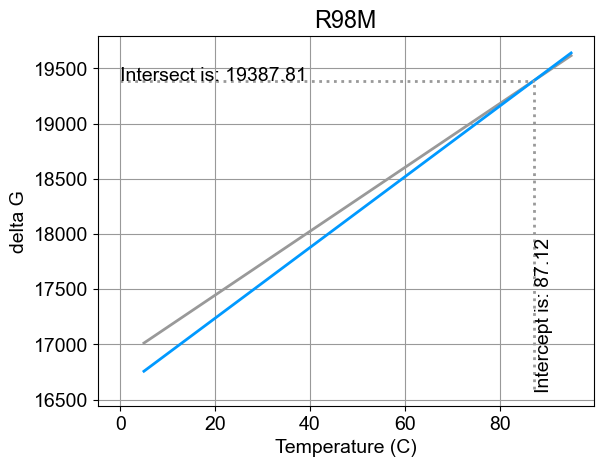

Intercept, x-Slope: 
 Intercept   -270.251155
x              3.102166
dtype: float64
Y Intercept is: 87.12


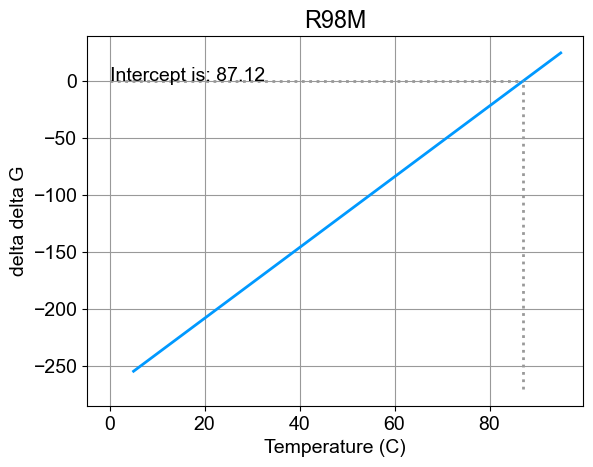

######################## D116M ########################


FileNotFoundError: [Errno 2] No such file or directory: './input_data/eyring/d116m_eyring.csv'

In [17]:
######For temperatures 5 through 35C with 5000 iterations of bootstrapping#########

energetics_df_all = pd.DataFrame()

mutant = ('DL121','A9N','M16A','M16P','G86K',\
          'D87A','R98M','D116M','H124Q','D127W')

csv_name = ("./input_data/eyring/dl121_eyring.csv",\
            "./input_data/eyring/a9n_eyring.csv",\
            "./input_data/eyring/m16a_eyring.csv",\
            "./input_data/eyring/m16p_eyring.csv",\
            "./input_data/eyring/g86k_eyring.csv",\
            "./input_data/eyring/d87a_eyring.csv",\
            "./input_data/eyring/r98m_eyring.csv",\
            "./input_data/eyring/d116m_eyring.csv",\
            "./input_data/eyring/h124q_eyring.csv",\
            "./input_data/eyring/d127w_eyring.csv")



for idx, mut in enumerate(mutant):
    
    print('######################## %s ########################' % mut)
    if mut == 'DL121':
        dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std, \
        lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
        kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
        dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
        calculated_intersect, calculated_intercept, \
        delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std, \
        ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std, \
        dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121 \
        = enthalpy_entropy_looper_DL121(csv_name[idx],5000,0,7,17.5,mut,"no") #In the looping function the input values correspond to:
    else:
##this is the function of functions from the cell above. 
        dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std, \
        lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
        kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
        dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
        calculated_intersect, calculated_intercept, \
        delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
        ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std \
        = enthalpy_entropy_looper(csv_name[idx],5000,0,7,17.5,mut,"no", \
                                 dark_enthalpy_list_DL121, dark_entropy_list_DL121, \
                                  lit_enthalpy_list_DL121, lit_entropy_list_DL121) #In the looping function the input values correspond to:
    #1st entry is path to the CSV name
    #3rd and 4th numbers are temp discernment 0=5, 7=35,
    #5th number is temp in C
    #6th is the mutation name, dont change
    #7th is if to save the figure
    #5000 bootstraps takes ~15 minutes
    
    temp = pd.DataFrame([[mutant[idx],csv_name[idx],\
                              dark_enthalpy_mean,dark_enthalpy_std,dark_entropy_mean,dark_entropy_std,\
                                     lit_enthalpy_mean,lit_enthalpy_std,lit_entropy_mean,lit_entropy_std,\
                         kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std,\
                         dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std,\
                         calculated_intersect, calculated_intercept,\
                         delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
                         ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std]],\
                            columns=['mutant','csv',\
                                     'dark_enthalpy_mean','dark_enthalpy_std','dark_entropy_mean','dark_entropy_std',\
                                     'lit_enthalpy_mean','lit_enthalpy_std','lit_entropy_mean','lit_entropy_std',\
                                    'kcat_dark_mean', 'kcat_dark_std', 'kcat_lit_mean', 'kcat_lit_std', 'kcat_ratio_mean', 'kcat_ratio_std',\
                                    'dG_dark_mean', 'dG_dark_std', 'dG_lit_mean', 'dG_lit_std', 'ddelta_G_mean', 'ddelta_G_std',\
                                    'calculated_intersect', 'calculated_intercept',\
                                    'delta_entropy_mean', 'delta_entropy_std', 'delta_enthalpy_mean', 'delta_enthalpy_std',\
                                    'ddelta_entropy_mean', 'ddelta_entropy_std', 'ddelta_enthalpy_mean', 'ddelta_enthalpy_std'])

    energetics_df_all = pd.concat([energetics_df_all, temp])
#save out    
#energetics_df_all.to_csv('./output/energetics_df_5-35C_5000boot_17.5.csv')

energetics_df_all

This section runs the functions for each proten, plots them, calls the energetics calculations, and saves them into a 
pandas dataframe named energetics_df. This is done for kinetics measurments between 10 and 35C with 5000 iterations of boostrapping.
The point of this second section is to have a second dataframe to allow checking on the effect of 5C samples, which may suffer from "cold denaturation".

In [ ]:
#For temperatures 10 through 35C with 5000 iterations of boostrapping

energetics_df = pd.DataFrame()

mutant = ('DL121','A9N','M16A','M16P','G86K',\
          'D87A','R98M','D116M','H124Q','D127W')

csv_name = ("./input_data/eyring/dl121_eyring.csv",\
            "./input_data/eyring/a9n_eyring.csv",\
            "./input_data/eyring/m16a_eyring.csv",\
            "./input_data/eyring/m16p_eyring.csv",\
            "./input_data/eyring/g86k_eyring.csv",\
            "./input_data/eyring/d87a_eyring.csv",\
            "./input_data/eyring/r98m_eyring.csv",\
            "./input_data/eyring/d116m_eyring.csv",\
            "./input_data/eyring/h124q_eyring.csv",\
            "./input_data/eyring/d127w_eyring.csv")



for idx, mut in enumerate(mutant):
    
    print('######################## %s ########################' % mut)
    if mut == 'DL121':
        dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std, \
        lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
        kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
        dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
        calculated_intersect, calculated_intercept, \
        delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std, \
        ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std, \
        dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121 \
        = enthalpy_entropy_looper_DL121(csv_name[idx],5000,1,7,30,mut,"no") #In the looping function the input values correspond to:
    else:
##this is the function of functions from the cell above. 
        dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std, \
        lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
        kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
        dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
        calculated_intersect, calculated_intercept, \
        delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
        ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std \
        = enthalpy_entropy_looper(csv_name[idx],5000,1,7,30,mut,"no", \
                                 dark_enthalpy_list_DL121, dark_entropy_list_DL121, \
                                  lit_enthalpy_list_DL121, lit_entropy_list_DL121) #In the looping function the input values correspond to:
    #1st entry is path to the CSV name
    #3rd and 4th numbers are temp discernment 0=5, 7=35,
    #5th number is temp in C
    #6th is the mutation name, dont change
    #7th is if to save the figure
    #5000 bootstraps takes ~15 minutes
    
    temp = pd.DataFrame([[mutant[idx],csv_name[idx],\
                              dark_enthalpy_mean,dark_enthalpy_std,dark_entropy_mean,dark_entropy_std,\
                                     lit_enthalpy_mean,lit_enthalpy_std,lit_entropy_mean,lit_entropy_std,\
                         kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std,\
                         dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std,\
                         calculated_intersect, calculated_intercept,\
                         delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
                         ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std]],\
                            columns=['mutant','csv',\
                                     'dark_enthalpy_mean','dark_enthalpy_std','dark_entropy_mean','dark_entropy_std',\
                                     'lit_enthalpy_mean','lit_enthalpy_std','lit_entropy_mean','lit_entropy_std',\
                                    'kcat_dark_mean', 'kcat_dark_std', 'kcat_lit_mean', 'kcat_lit_std', 'kcat_ratio_mean', 'kcat_ratio_std',\
                                    'dG_dark_mean', 'dG_dark_std', 'dG_lit_mean', 'dG_lit_std', 'ddelta_G_mean', 'ddelta_G_std',\
                                    'calculated_intersect', 'calculated_intercept',\
                                    'delta_entropy_mean', 'delta_entropy_std', 'delta_enthalpy_mean', 'delta_enthalpy_std',\
                                    'ddelta_entropy_mean', 'ddelta_entropy_std', 'ddelta_enthalpy_mean', 'ddelta_enthalpy_std'])


    energetics_df = pd.concat([energetics_df, temp])
    
#energetics_df.to_csv('./output/energetics_df_10-35C_5000boot.csv')
energetics_df

This section allows loading in the CSV files to be able to produce plots and graphs without having to run the long calculations above. 
This is currently set to load in the 30C samples. 

In [19]:
#load in energetics data to skip the above. 
load_saved_data = "yes"
temperature = 303
if load_saved_data == 'yes':
    energetics_path_all = './output/energetics_df_5-35C_5000boot.csv' #30C
    #energetics_path_all = './output/energetics_df_5-35C_5000boot_17.5.csv' #17.5C
    energetics_df_all = pd.read_csv(energetics_path_all,header=(0))
    energetics_path = './output/energetics_df_10-35C_5000boot.csv'
    energetics_df = pd.read_csv(energetics_path,header=(0))
mutant = ('DL121','A9N','M16A','M16P','G86K',\
          'D87A','R98M','D116M','H124Q','D127W')

In [20]:
#now I want to reindex the pandas dataframe so that the mutants are sorted by this allosteric effect. 
energetics_df_all.sort_values(by=['kcat_ratio_mean'], inplace=True)
energetics_df_all = energetics_df_all.reset_index(drop=True)

In [21]:
#lets calculate the allosteric effect of kcat_lit/kcat_dark relative to DL121 so that we can make a color bar of it. 
#currently set for 30C
color_scale = []
y = energetics_df_all[['kcat_ratio_mean']].to_numpy().T
for i, txt in enumerate(energetics_df_all['mutant']):
#    color = np.subtract(y[0][i],y[0][5]) #17.5C
    color = np.subtract(y[0][i],y[0][3]) #30C
    color_scale.append(color)
offset = colors.TwoSlopeNorm(0)
offset(color_scale)
wowzers = plt.cm.RdBu(offset(color_scale))
energetics_df_all

Unnamed: 0 mutant                                   csv  \
0           0   M16P   ./input_data/eyring/m16p_eyring.csv   
1           0  D116M  ./input_data/eyring/d116m_eyring.csv   
2           0   D87A   ./input_data/eyring/d87a_eyring.csv   
3           0  DL121  ./input_data/eyring/dl121_eyring.csv   
4           0   G86K   ./input_data/eyring/g86k_eyring.csv   
5           0  H124Q  ./input_data/eyring/h124q_eyring.csv   
6           0    A9N    ./input_data/eyring/a9n_eyring.csv   
7           0   R98M   ./input_data/eyring/r98m_eyring.csv   
8           0   M16A   ./input_data/eyring/m16a_eyring.csv   
9           0  D127W  ./input_data/eyring/d127w_eyring.csv   

   dark_enthalpy_mean  dark_enthalpy_std  dark_entropy_mean  dark_entropy_std  \
0           13.156230           0.646546         -20.185232          2.164338   
1            6.458452           0.328429         -36.433128          1.120010   
2           11.662790           0.394364         -20.065079          1.339850   
3           12.616080           0.161810         -17.353539          0.550739   
4            8.321717           0.255156         -32.034706          0.866960   
5            8.909612           0.311516         -29.861074          1.058777   
6           10.484176           0.499373         -23.851298          1.714027   
7            8.962137           0.265481         -28.958195          0.899863   
8           12.971744           0.696919         -17.809741          2.334727   
9            8.359063           0.950598         -32.831763          3.247319   

   lit_enthalpy_mean  lit_enthalpy_std  lit_entropy_mean  ...  \
0          11.742906          0.840369        -24.812622  ...   
1           5.312499          0.301670        -40.048300  ...   
2           9.520078          0.432347        -26.927964  ...   
3          10.951452          0.454782        -22.421308  ...   
4           7.641702          0.275955        -33.842019  ...   
5           7.859143          0.460853        -32.856213  ...   
6           7.910597          0.866592        -31.803239  ...   
7           7.842981          0.253370        -32.065071  ...   
8          11.303475          0.474708        -22.701684  ...   
9           7.303681          0.633547        -35.382564  ...   

   delta_entropy_mean  delta_entropy_std  delta_enthalpy_mean  \
0        -1402.099209        1090.422684         -1413.323832   
1        -1095.397180         462.848164         -1145.952972   
2        -2079.453947         603.155079         -2142.711267   
3        -1535.533977         493.762191         -1664.628431   
4         -547.615806         383.561236          -680.014546   
5         -907.527338         569.282703         -1050.468971   
6        -2409.438269        1026.990722         -2573.579134   
7         -941.383261         380.753720         -1119.155365   
8        -1482.258952         850.823855         -1668.268930   
9         -772.892586        1196.179184         -1055.381127   

   delta_enthalpy_std  ddelta_entropy_mean  ddelta_entropy_std  \
0         1075.052638           133.434768         1191.126088   
1          444.738453           440.136797          673.333655   
2          581.709274          -543.919970          783.496496   
3          478.908575             0.000000            0.000000   
4          373.216720           987.918171          632.588823   
5          556.339325           628.006639          753.793460   
6          998.951099          -873.904293         1132.315661   
7          368.720972           594.150716          618.500906   
8          835.520597            53.275025          989.135179   
9         1149.550081           762.641391         1293.350637   

   ddelta_enthalpy_mean  ddelta_enthalpy_std  fol_distance  corex score  
0            251.304598          1171.018071         10.24          NaN  
1            518.675458           650.319537         11.87          NaN  
2           -478.082837           757.003122   

plot the enthalpy of activation with error. 

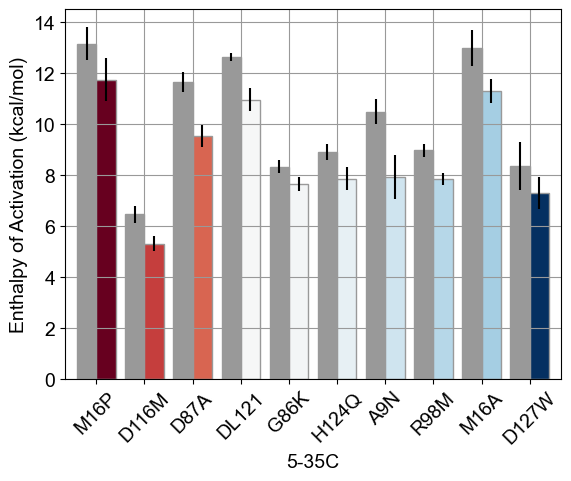

In [22]:
########enthalpy of activation
yerr = energetics_df_all[['dark_enthalpy_std', 'lit_enthalpy_std']].to_numpy().T

#wowzers = np.concatenate((plt.cm.RdBu(offset(color_scale)), plt.cm.RdBu(offset(color_scale))), axis=0)
wowzers = plt.cm.RdBu(offset(color_scale))

#edge_colors = np.where(energetics_df_all.index==dark_enthalpy_mean, 'r', 'w')

#color=(plt.cm.RdBu(offset(np.concatenate((color_scale, color_scale), axis=0)))))

ax = energetics_df_all.plot.bar(x='mutant', y=['dark_enthalpy_mean','lit_enthalpy_mean'],
                                yerr=yerr, 
                                rot = 0, 
                                color={'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': wowzers},
                                edgecolor="#999999",#{'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': "#0099FF"}
                                legend=False,
                                width=0.8
                                ,)

ax.set_ylabel("Enthalpy of Activation (kcal/mol)")
ax.set_xlabel("5-35C")
ax.set_xticklabels(energetics_df_all['mutant'],rotation=45)
#ax.legend(['Dark', 'Lit'])

if to_plot == 'yes':
    figure_name = ('enthalpy_of_activation.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show()


Plots the distance to the active site. This was calculated by any atom's closest distance to the folate in the alphafold homology model. 
Those calculations were done in pymol. The coloring is from the kcat ratio to DL121

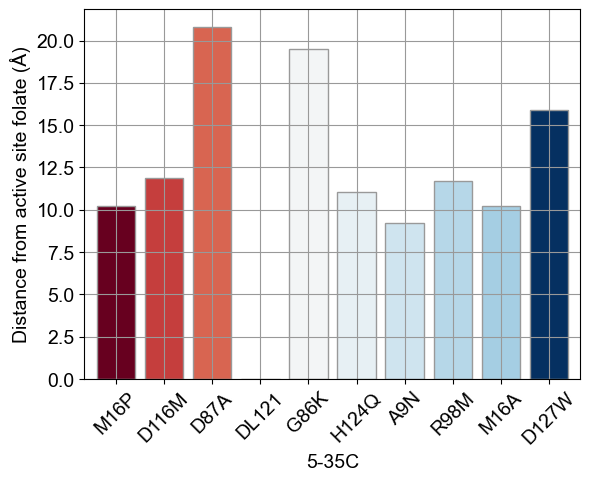

In [23]:
#color by active site distance. (any atom's closest distance to the folate in the homology model)
distance = [10.24,11.87,20.8,0,19.52,11.04,9.24,20.8,10.24,15.88]
########
yerr = energetics_df_all[['dark_enthalpy_std', 'lit_enthalpy_std']].to_numpy().T
wowzers = plt.cm.RdBu(offset(color_scale))

ax = energetics_df_all.plot.bar(x='mutant', y=['fol_distance'],
                                rot = 0, 
                                color={'fol_distance': wowzers},
                                edgecolor="#999999",#{'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': "#0099FF"}
                                legend=False,
                                width=0.8
                                ,)#,stacked=True)
ax.set_ylabel("Distance from active site folate (Å)")
ax.set_xlabel("5-35C")
ax.set_xticklabels(energetics_df_all['mutant'],rotation=45)
if to_plot == 'yes':
    figure_name = ('distance_from_active_fol.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show()


plot the entropy of activation with error.

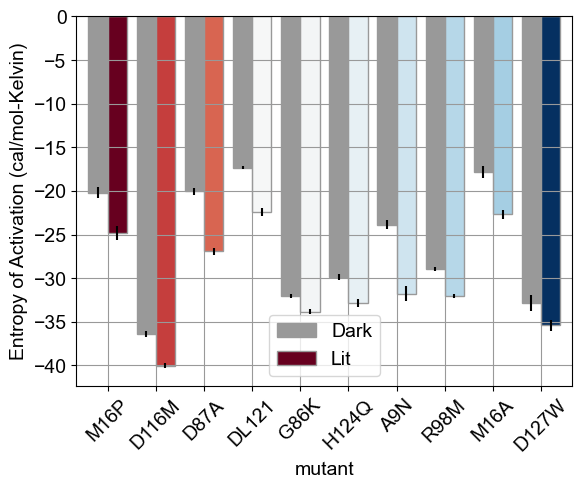

In [24]:

########
yerr = energetics_df_all[['dark_enthalpy_std', 'lit_enthalpy_std']].to_numpy().T

#wowzers = np.concatenate((plt.cm.RdBu(offset(color_scale)), plt.cm.RdBu(offset(color_scale))), axis=0)
wowzers = plt.cm.RdBu(offset(color_scale))

#edge_colors = np.where(energetics_df_all.index==dark_enthalpy_mean, 'r', 'w')

#color=(plt.cm.RdBu(offset(np.concatenate((color_scale, color_scale), axis=0)))))

ax = energetics_df_all.plot.bar(x='mutant', y=['dark_entropy_mean','lit_entropy_mean'],
                                yerr=yerr, 
                                rot = 0, 
                                color={'dark_entropy_mean': "#999999", 'lit_entropy_mean': wowzers},
                                edgecolor="#999999",#{'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': "#0099FF"}
                                legend=False,
                                width=0.8
                                ,)#,stacked=True)



####################

ax.set_ylabel("Entropy of Activation (cal/mol-Kelvin)")
#ax.set_xlabel("5-35C")
ax.set_xticklabels(energetics_df_all['mutant'],rotation=45)
ax.legend(['Dark', 'Lit'])

if to_plot == 'yes':
    figure_name = ('entropy_of_activation.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show()

Compare the two temperature ranges. 

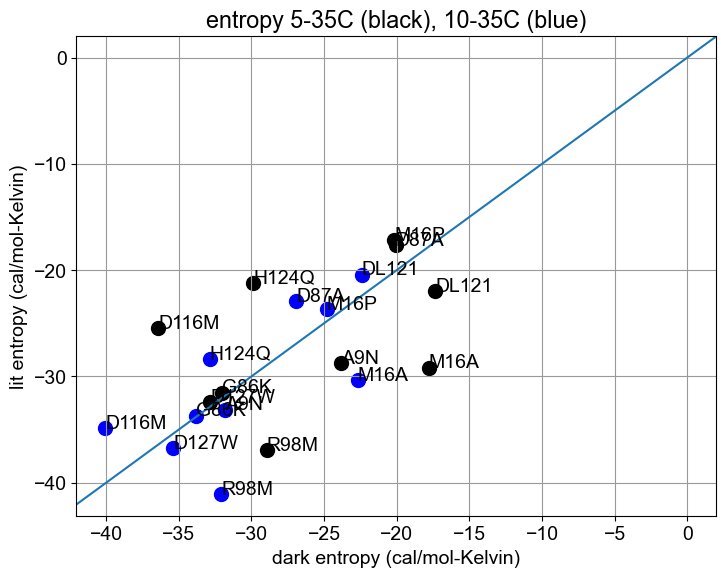

In [25]:
ax = plt
a1 = ax.figure().add_axes([0,0,1,1])
xerr = energetics_df_all[['dark_entropy_std']].to_numpy().T
yerr = energetics_df[['dark_entropy_std']].to_numpy().T
x = energetics_df_all[['dark_entropy_mean']].to_numpy().T
y = energetics_df[['dark_entropy_mean']].to_numpy().T
ax.scatter(x, y, color='black')

x1 = energetics_df_all[['lit_entropy_mean']].to_numpy().T
y1 = energetics_df[['lit_entropy_mean']].to_numpy().T
ax.scatter(x1, y1, color='blue')


ax.axline((0, 0), slope=1)
plt.xlabel('dark entropy (cal/mol-Kelvin)')
plt.ylabel('lit entropy (cal/mol-Kelvin)')
title = ('entropy 5-35C (black), 10-35C (blue)')
plt.title(title)
plt.grid(True)
for i, txt in enumerate(energetics_df_all['mutant']):
    plt.annotate(txt, (x[0][i], y[0][i]))
    
for i, txt in enumerate(energetics_df_all['mutant']):
    plt.annotate(txt, (x1[0][i], y1[0][i]))

plt.show() 

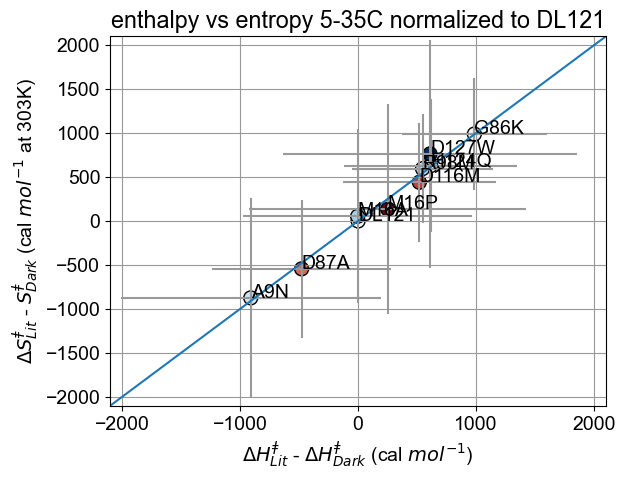

In [26]:
#plot enthalpy vs entropy 5-35C normalized to DL121
x_err = energetics_df_all[['ddelta_enthalpy_std']].to_numpy().T
x = energetics_df_all[['ddelta_enthalpy_mean']].to_numpy().T
y_err = energetics_df_all[['ddelta_entropy_std']].to_numpy().T
y = energetics_df_all[['ddelta_entropy_mean']].to_numpy().T
for i, txt in enumerate(energetics_df_all['mutant']):
    plt.annotate(txt, (x[0][i], y[0][i]))
    plt.errorbar(x[0][i], y[0][i], yerr=y_err[0][i], xerr=x_err[0][i], c="#999999" )
ax = plt
ax.axline((0, 0), slope=1)
ax.ylim(-2100, 2100)
ax.xlim(-2100, 2100)
plt.grid(True)
ax.scatter(x, y, c=color_scale, cmap='RdBu', edgecolors='black', norm=TwoSlopeNorm(0))
plt.xlabel("$ΔH^{ǂ}_{Lit}$ - $ΔH^{ǂ}_{Dark}$ (cal $mol^{-1}$)")
ylabel = ("$ΔS^{ǂ}_{Lit}$ - $S^{ǂ}_{Dark}$ (cal $mol^{-1}$ at " + str(temperature) + "K)")
plt.ylabel(ylabel)
#plt.ylabel('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ 290.5)')
title = ('enthalpy vs entropy 5-35C normalized to DL121')
plt.title(title)
#plt.colorbar()
if to_plot == 'yes':
    figure_name = ('ddEnthalpy_vs_ddEntropy_5-35C_at30_normalized.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show() 

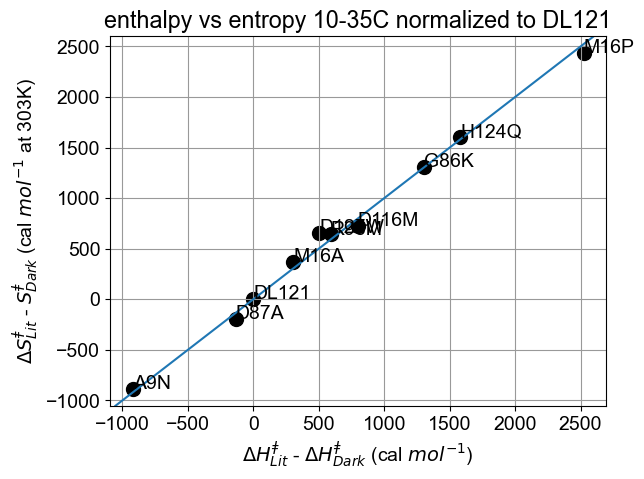

In [27]:
#plot enthalpy vs entropy 10-35C normalized to DL121
d_entropy = np.subtract(energetics_df['lit_entropy_mean'].to_numpy().T\
                        ,energetics_df['dark_entropy_mean'].to_numpy().T)
dd_entropy = np.subtract(d_entropy,d_entropy[0])
dd_entropy = np.multiply(dd_entropy,temperature)
d_enthalpy = np.subtract(energetics_df['lit_enthalpy_mean'].to_numpy().T\
                        ,energetics_df['dark_enthalpy_mean'].to_numpy().T)
dd_enthalpy = np.subtract(d_enthalpy,d_enthalpy[0])
dd_enthalpy = np.multiply(dd_enthalpy,1000)
for i, txt in enumerate(mutant):
    plt.annotate(txt, (dd_enthalpy[i], dd_entropy[i]))
    
ax.axline((0, 0), slope=1)

ax = plt
ax.scatter(dd_enthalpy, dd_entropy, color='black')
plt.xlabel("$ΔH^{ǂ}_{Lit}$ - $ΔH^{ǂ}_{Dark}$ (cal $mol^{-1}$)")
ylabel = ("$ΔS^{ǂ}_{Lit}$ - $S^{ǂ}_{Dark}$ (cal $mol^{-1}$ at " + str(temperature) + "K)")
plt.ylabel(ylabel)
title = ('enthalpy vs entropy 10-35C normalized to DL121')
plt.grid(True)
plt.title(title)
if to_plot == 'yes':
    figure_name = ('ddEnthalpy_vs_ddEntropy_10-35C_at30.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')
plt.show() 

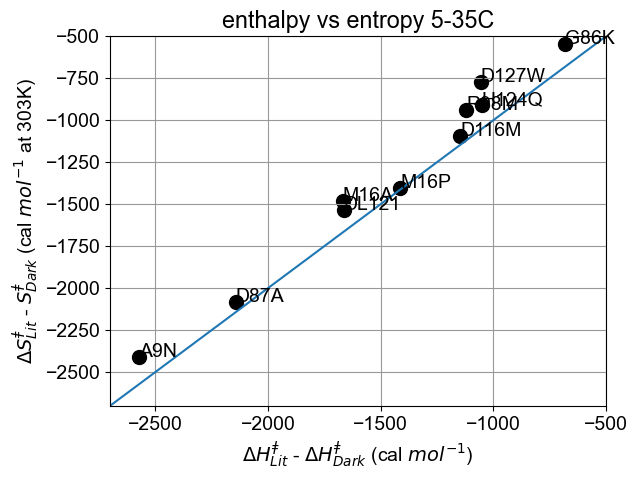

In [28]:
#calculated without bootstrapping

dd_entropy_all = np.subtract(energetics_df_all['lit_entropy_mean'].to_numpy().T\
                        ,energetics_df_all['dark_entropy_mean'].to_numpy().T)
#dd_entropy_all = np.subtract(d_entropy_all,d_entropy_all[0])
dd_entropy_all = np.multiply(dd_entropy_all,temperature)
dd_enthalpy_all = np.subtract(energetics_df_all['lit_enthalpy_mean'].to_numpy().T\
                        ,energetics_df_all['dark_enthalpy_mean'].to_numpy().T)
#dd_enthalpy_all = np.subtract(d_enthalpy_all,d_enthalpy_all[0])
dd_enthalpy_all = np.multiply(dd_enthalpy_all,1000)

for i, txt in enumerate(energetics_df_all['mutant']):
    plt.annotate(txt, (dd_enthalpy_all[i], dd_entropy_all[i]))
ax = plt
ax.axline((-1500, -1500), slope=1)
ax.ylim(-2700, -500)
ax.xlim(-2700, -500)
plt.grid(True)
ax.scatter(dd_enthalpy_all, dd_entropy_all, color='black')
#$cm^{2}$ $dmol^{-1}$
plt.xlabel("$ΔH^{ǂ}_{Lit}$ - $ΔH^{ǂ}_{Dark}$ (cal $mol^{-1}$)")
#plt.xlabel('ΔΔEnthalpy of Activation (lit-dark) (cal/mol)')
ylabel = ("$ΔS^{ǂ}_{Lit}$ - $S^{ǂ}_{Dark}$ (cal $mol^{-1}$ at " + str(temperature) + "K)")
#ylabel = ('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ ' + str(temperature) + ')')
plt.ylabel(ylabel)
#plt.ylabel('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ 290.5)')
title = ('enthalpy vs entropy 5-35C')
plt.title(title)
if to_plot == 'yes':
    figure_name = ('ddEnthalpy_vs_ddEntropy_5-35C_at30_notNormalized.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show() 

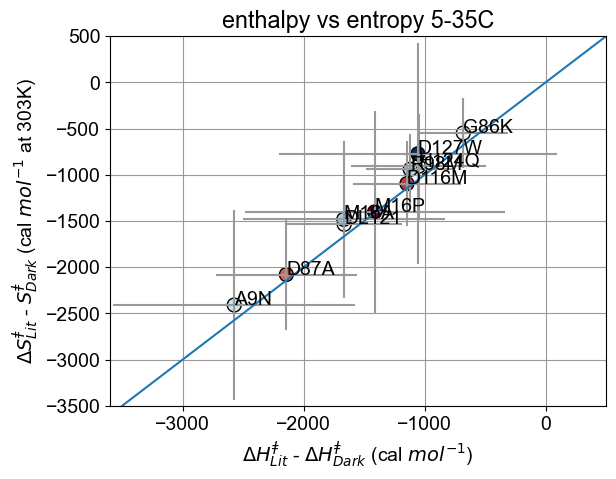

In [29]:
#calculated from bootstrapping

x_err = energetics_df_all[['delta_enthalpy_std']].to_numpy().T
x = energetics_df_all[['delta_enthalpy_mean']].to_numpy().T
y_err = energetics_df_all[['delta_entropy_std']].to_numpy().T
y = energetics_df_all[['delta_entropy_mean']].to_numpy().T
for i, txt in enumerate(energetics_df_all['mutant']):
    #plt.annotate(txt, (dd_enthalpy_all[i], dd_entropy_all[i]))
    plt.annotate(txt, (x[0][i], y[0][i]))
    plt.errorbar(x[0][i], y[0][i], yerr=y_err[0][i], xerr=x_err[0][i], c="#999999" )
ax = plt
ax.axline((0, 0), slope=1)
ax.ylim(-3500, 500)
ax.xlim(-3600, 500)
plt.grid(True)
#plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
#ax.scatter(dd_enthalpy_all, dd_entropy_all, c="#0099FF" , edgecolors='black')
ax.scatter(x, y, c=color_scale, cmap='RdBu', edgecolors='black', norm=TwoSlopeNorm(0))
plt.xlabel("$ΔH^{ǂ}_{Lit}$ - $ΔH^{ǂ}_{Dark}$ (cal $mol^{-1}$)")
ylabel = ("$ΔS^{ǂ}_{Lit}$ - $S^{ǂ}_{Dark}$ (cal $mol^{-1}$ at " + str(temperature) + "K)")
plt.ylabel(ylabel)
#plt.ylabel('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ 290.5)')
title = ('enthalpy vs entropy 5-35C')
plt.title(title)
#plt.colorbar()
if to_plot == 'yes':
    figure_name = ('ddEnthalpy_vs_ddEntropy_5-35C_at30.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show() 


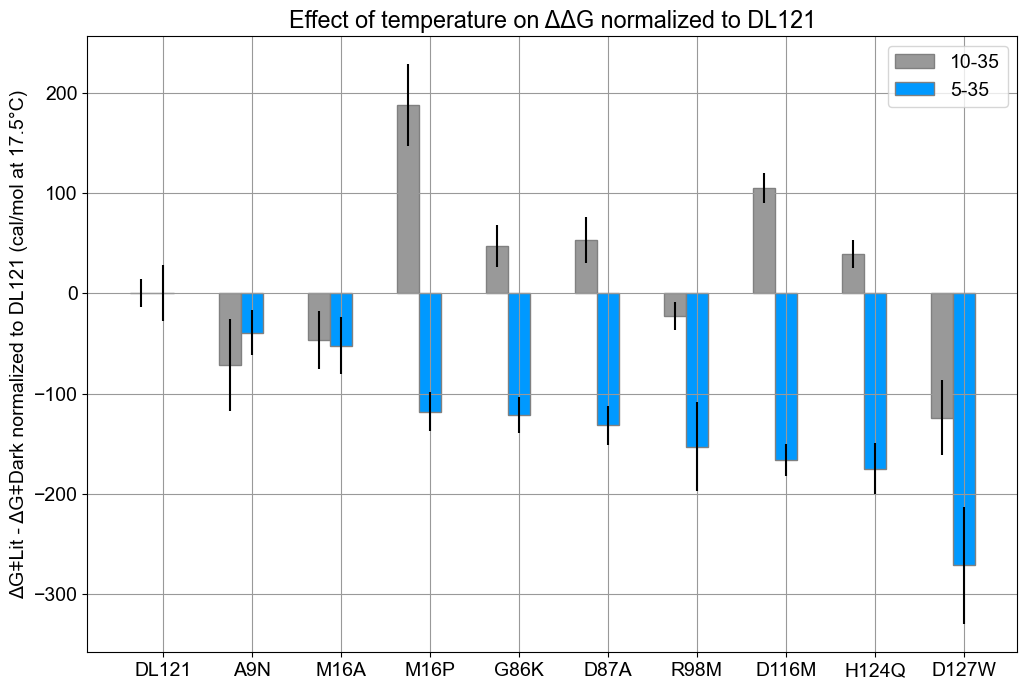

In [30]:
#goal is to compare the effect of slicing temperature on allostery. 
dd_G = np.subtract(energetics_df['ddelta_G_mean'],energetics_df['ddelta_G_mean'][0])
dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][0])
fig = plt.subplots(figsize =(12, 8)) 
barWidth = 0.25
br1 = np.arange(len(dd_G)) 
br2 = [x + barWidth for x in br1] 

yerr = energetics_df[['ddelta_G_std']].to_numpy().T
yerr_all = energetics_df_all[['ddelta_G_std']].to_numpy().T
plt.bar(br1, dd_G, yerr=yerr, edgecolor ='grey', label ='10-35',width = barWidth,color ="#999999")
plt.bar(br2, dd_G_all, yerr=yerr_all, edgecolor ='grey', label ='5-35',width = barWidth,color ="#0099FF")       

plt.xticks([r + barWidth for r in range(len(dd_G))], 
       mutant)   
plt.legend()
#plt.xlabel('ΔGǂLit - ΔGǂDark (kcal/mol at 17.5°C)')
plt.ylabel('ΔGǂLit - ΔGǂDark normalized to DL121 (cal/mol at 17.5°C)')
title = ('Effect of temperature on ΔΔG normalized to DL121')
plt.title(title)
if to_plot == 'yes':
    figure_name = ('Effect_of_temperature_slice_on_ΔΔG.pdf')
    #plt.savefig('./output/%s' % figure_name, bbox_inches='tight')
plt.show()

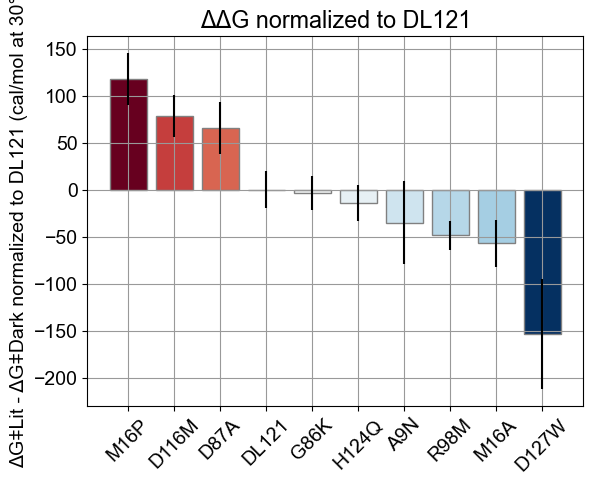

In [31]:
#goal is to compare the effect of slicing temperature on allostery. TLDR some, but not consistant. Probably best to leave as is. 
#dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][5])#17.5C
dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][3])#30C
barWidth = 0.25
br1 = np.arange(len(dd_G_all)) 
yerr_all = energetics_df_all[['ddelta_G_std']].to_numpy().T
plt.bar(br1, dd_G_all, yerr=yerr_all, edgecolor ='grey',width = 0.8,color =wowzers) 

br1 = np.arange(len(dd_G_all)) 
br2 = [x + barWidth for x in br1] 
#plt.xticks(energetics_df_all['mutant'])
#plt.xticks(labels=energetics_df_all['mutant'])   
plt.xticks([r for r in range(len(dd_G_all))], 
       energetics_df_all['mutant'],rotation=45)   




#plt.legend()
#plt.xlabel('ΔGǂLit - ΔGǂDark (kcal/mol at 17.5°C)')
#plt.set_xticklabels(energetics_df_all['mutant'],rotation=45)
plt.ylabel('ΔGǂLit - ΔGǂDark normalized to DL121 (cal/mol at 30°C)')
title = ('ΔΔG normalized to DL121')
plt.title(title)
to_plot = "no"
if to_plot == 'yes':
    figure_name = ('ddG.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')
plt.show()

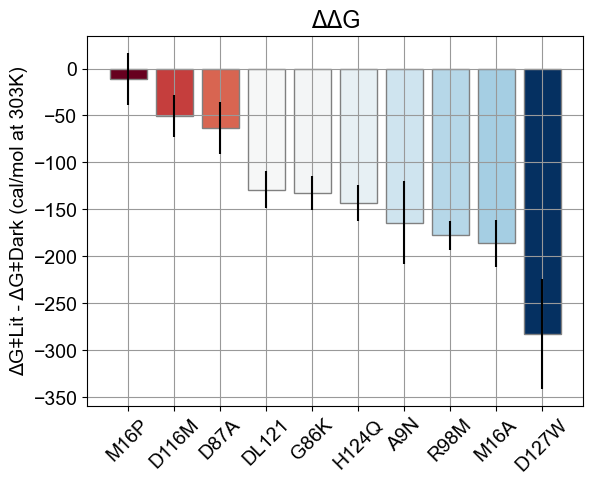

In [32]:
#goal is to compare the effect of slicing temperature on allostery. TLDR some, but not consistant. Probably best to leave as is. 
#dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][5])#17.5C
#dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][3])#30C
barWidth = 0.25
br1 = np.arange(len(energetics_df_all['ddelta_G_mean'])) 
yerr_all = energetics_df_all[['ddelta_G_std']].to_numpy().T
plt.bar(br1, energetics_df_all['ddelta_G_mean'], yerr=yerr_all, edgecolor ='grey',width = 0.8,color =wowzers) 

br1 = np.arange(len(dd_G_all)) 
br2 = [x + barWidth for x in br1] 
#plt.xticks(energetics_df_all['mutant'])
#plt.xticks(labels=energetics_df_all['mutant'])   
plt.xticks([r for r in range(len(dd_G_all))], 
       energetics_df_all['mutant'],rotation=45)   




#plt.legend()
#plt.xlabel('ΔGǂLit - ΔGǂDark (kcal/mol at 17.5°C)')
#plt.set_xticklabels(energetics_df_all['mutant'],rotation=45)
plt.ylabel('ΔGǂLit - ΔGǂDark (cal/mol at 303K)')
title = ('ΔΔG')
plt.title(title)
to_plot = "no"
if to_plot == 'yes':
    figure_name = ('ddG_unnormalized_303K.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')
plt.show()

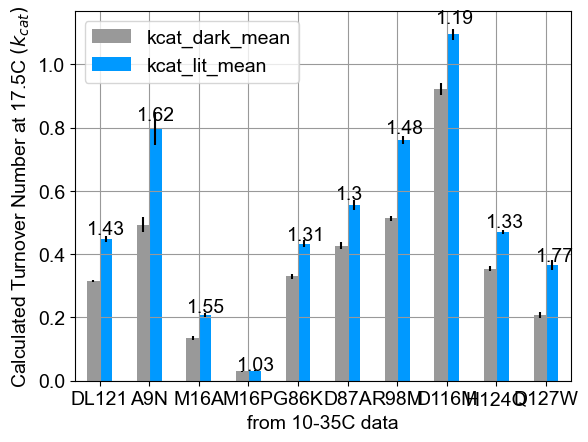

In [33]:
yerr = energetics_df[['kcat_dark_std', 'kcat_lit_std']].to_numpy().T

ax = energetics_df.plot.bar(x='mutant', y=['kcat_dark_mean','kcat_lit_mean']\
                            ,yerr=yerr, rot = 0, color=["#999999","#0099FF"])

ax.set_ylabel("Calculated Turnover Number at 17.5C $(k_{cat})$")
ax.set_xlabel("from 10-35C data")

kcat_ratio = np.divide(energetics_df['kcat_lit_mean'].to_numpy().T\
                        ,energetics_df['kcat_dark_mean'].to_numpy().T)
kcat_ratio = np.around(kcat_ratio, decimals=2, out=None)

#this section allows me to put the ratio on the plot above the bar. 
i=0
for p in ax.patches:
    ax.annotate(kcat_ratio[i], (p.get_x() * 1.005, p.get_height() * 1.03 * kcat_ratio[i]))
    i=i+1
    if i == len(mutant):
        break

plt.show()


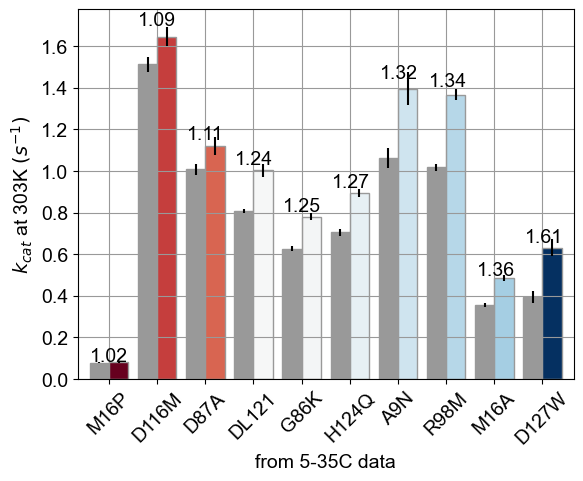

In [34]:
#from 5-35C data#
########
yerr = energetics_df_all[['kcat_dark_std', 'kcat_lit_std']].to_numpy().T

#wowzers = np.concatenate((plt.cm.RdBu(offset(color_scale)), plt.cm.RdBu(offset(color_scale))), axis=0)
wowzers = plt.cm.RdBu(offset(color_scale))


ax = energetics_df_all.plot.bar(x='mutant', y=['kcat_dark_mean','kcat_lit_mean'],
                                yerr=yerr, 
                                rot = 0, 
                                color={'kcat_dark_mean': "#999999", 'kcat_lit_mean': wowzers},
                                edgecolor="#999999",#{'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': "#0099FF"}
                                legend=False,
                                width=0.8
                                
                                ,)#,stacked=True)
########Add hatches######
bars = ax.patches
hatches = '//////////'#10 hatches for first 10 bars. 
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
######################

####Ratio above the numbers
kcat_ratio_all = np.around(energetics_df_all['kcat_ratio_mean'], decimals=2, out=None)

i=0
for p in ax.patches:
    ax.annotate(kcat_ratio_all[i], (p.get_x() * 1.005, p.get_height() * 1.03 * kcat_ratio_all[i]))
    i=i+1
    if i == len(energetics_df_all['mutant']):
        break

#######


ax.set_ylabel("$k_{cat}$ at 303K $(s^{-1})$")
ax.set_xlabel("from 5-35C data")

ax.set_xticklabels(energetics_df_all['mutant'],rotation=45)
#ax.legend(['Dark', 'Lit'])
to_plot = 'no'
if to_plot == 'yes':
    figure_name = ('kcat_back-calculate.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show()

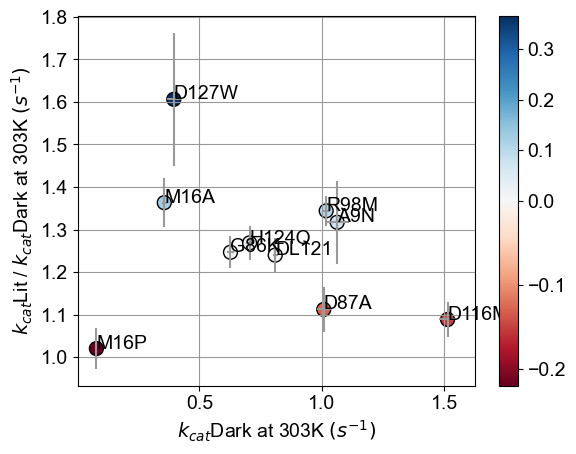

In [35]:
#calculated from bootstrapping

x_err = energetics_df_all[['kcat_dark_std']].to_numpy().T
x = energetics_df_all[['kcat_dark_mean']].to_numpy().T
y_err = energetics_df_all[['kcat_ratio_std']].to_numpy().T
y = energetics_df_all[['kcat_ratio_mean']].to_numpy().T
for i, txt in enumerate(energetics_df_all['mutant']):

    plt.annotate(txt, (x[0][i], y[0][i]))
    plt.errorbar(x[0][i], y[0][i], yerr=y_err[0][i], xerr=x_err[0][i], c="#999999" )
ax = plt
plt.grid(True)
ax.scatter(x, y, c=color_scale, cmap='RdBu', edgecolors='black', norm=TwoSlopeNorm(0))
plt.xlabel("$k_{cat}$Dark at 303K $(s^{-1})$")
ylabel = ("$k_{cat}$Lit / $k_{cat}$Dark at 303K $(s^{-1})$")
plt.ylabel(ylabel)
#plt.ylabel('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ 290.5)')
#title = ('enthalpy vs entropy 5-35C')
#plt.title(title)
plt.colorbar()

if to_plot == 'yes':
    figure_name = ('kcat_ratio_vs_kcat_dark.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show() 